In [1]:
#import
import os
import sys

import tqdm
import math
import wandb
import torch
import pylab
import logging

import numpy as np
import pandas as pd
import torch.nn as nn
import lightning.pytorch as pl
import matplotlib.pyplot as plt

from random import randint
from scipy.stats import chisquare, kstest
from scipy.optimize import curve_fit
from torchmetrics import MeanAbsoluteError
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from lightning.pytorch.loggers import WandbLogger
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import Callback, LearningRateMonitor, ModelCheckpoint

/var/folders/x_/hc_g5h8x4m12gf7wzzp8sx3w0000gq/T/ipykernel_46732/2713701154.py:13: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
#model
if True:
    class RMSELoss(torch.nn.Module):
        def __init__(self, add_abc=False):
            super(RMSELoss,self).__init__()
            self.add_abc = add_abc

        @staticmethod
        def func_cos(x, a, b, c):
            return a + b*torch.cos(2*x) + c*torch.cos(x)

        def forward(self, x, y_hat, y, w, A, B, C):
            if self.add_abc:
                phi = x[:, 4]
                criterion = torch.sqrt(torch.mean(w*(y_hat - y)**2)/torch.sum(w)) + \
                            torch.mul(hyperparams_dict.get('abc_loss_factor'), torch.mean(torch.abs(w*y - self.func_cos(phi,A,B,C)))/torch.sum(w))
            else:
                criterion = torch.sqrt(torch.mean(w * (y_hat - y) ** 2) / torch.sum(w))
            return criterion

    #params
    project_name = "MSU_interpol"

    logger_path = './wandb_local_logs'
    data_path = '../../data/clasdb_pi_plus_n.txt'

    hyperparams_dict = {
        'scale_data': False,
        'augment': False,
        'add_abc': False,
        'abc_loss_factor': 1,
        'augment_factor': 20,
        'test_size': 0.1,
        'batch_size': 256,
        'net_architecture': [5,60,80,100,120,140,240,340,440,640,2000,1040,640,340,240,140,100,80,60,20,1],
        'activation_function': nn.ReLU(),
        'loss_func': 'RMSELoss()',
        'optim_func': torch.optim.Adam,
        'max_epochs': 2000,
        'es_min_delta': 0.00001,
        'es_patience': 50,
        'lr': 0.001,
        'lr_factor':0.5,
        'lr_patience': 5,
        'lr_cooldown': 20,
    }


    logger_full_path = os.path.join(logger_path, project_name, 'spring-feather-42')

    os.makedirs(logger_full_path, exist_ok=True)
    logging.basicConfig(encoding='utf-8',
                        level=logging.DEBUG,
                        format='%(asctime)s : %(levelname)s : %(message)s',
                        handlers=[logging.FileHandler(os.path.join(logger_full_path, 'logs.log'), mode='w'),
                                  logging.StreamHandler(sys.stdout)],
                        force=True)

    class InterpolDataSet(Dataset):
        def __init__(self, features, labels, weights):
            self.features = features
            self.labels = labels
            self.weights = weights
            self.len = len(labels)

        def __getitem__(self, index):
            feature = self.features[index]
            label = self.labels[index]
            weights = self.weights[index]
            return feature, label, weights

        def __len__(self):
            return self.len

    class InterpolDataModule(pl.LightningDataModule):
        def __init__(self, hyperparams):
            super().__init__()
            self.df = None
            self.hyperparams = hyperparams
            self.train_dataset = None
            self.val_dataset = None

        def augment(self, new_augm):
            augm = pd.Series({'Ebeam': np.random.normal(loc=new_augm.Ebeam, scale=new_augm.Ebeam/30),
                               'W': np.random.normal(loc=new_augm.W, scale=new_augm.W/30),
                               'Q2': np.random.normal(loc=new_augm.Q2, scale=new_augm.Q2/30),
                               'cos_theta': np.clip(np.random.normal(loc=new_augm.cos_theta, scale=abs(new_augm.cos_theta/30)), -1, 1),
                               'phi': np.clip(np.random.normal(loc=new_augm.phi, scale=new_augm.phi/30), 0, 2*np.pi),
                               'dsigma_dOmega': np.random.normal(loc=new_augm.dsigma_dOmega, scale=new_augm.error/3),
                               'error': new_augm.error,
                               'weight': new_augm.weight,
                              })
            return augm

        def setup(self, stage):
            # data reading and preprocessing
            df = pd.read_csv(data_path, delimiter='\t', header=None)
            df.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi', 'dsigma_dOmega', 'error', 'id']
            df.loc[8314:65671, 'Ebeam'] = 5.754 # peculiarity of this dataset.
            df = df[~((df.Ebeam == 5.754) & (~df.Q2.isin([1.715, 2.050, 2.445, 2.915, 3.480, 4.155])))] # peculiarity of this dataset #2
            df['phi'] = df.phi.apply(lambda x: math.radians(x))
            df['weight'] = df['error'].apply(lambda x: x and 1 / x or 100) # x and 1 / x or 100  is just a reversed error but with validation 1/0 error in this case it will return 100
            df = df.drop('id', axis=1)
            df = df.iloc[df[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']].drop_duplicates().reset_index(drop=True).index]

            #train test split
            feature_columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']
            feature_columns_with_weights = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi', 'weight']

            feature_data = df[feature_columns_with_weights]
            label_data = df['dsigma_dOmega']

            if self.hyperparams.get('scale_data'):
                scaler_feature = StandardScaler()
                scaler_target = StandardScaler()
                feature_data = scaler_feature.fit_transform(feature_data)
                label_data = scaler_target.fit_transform(label_data.values.reshape(-1,1))
            else:
                pass

            if self.hyperparams.get('augment'):
                aug_series_list = []
                for i in tqdm.tqdm(df.itertuples()):
                    for _ in range(self.hyperparams.get('augment_factor')):
                        aug_series_list.append(self.augment(i))

                aug_df = pd.DataFrame(aug_series_list)
                df = pd.concat([df, aug_df])
            else:
                pass

            self.df = df

            train_feature_data, val_feature_data, train_label_data, val_label_data = train_test_split(feature_data,
                                                                                                      label_data,
                                                                                                      test_size=self.hyperparams.get('test_size'),
                                                                                                      random_state=1438)


            self.train_dataset = InterpolDataSet(torch.tensor(train_feature_data[feature_columns].values, dtype=torch.float32),
                                                 torch.tensor(train_label_data.values, dtype=torch.float32),
                                                 torch.tensor(train_feature_data['weight'].values, dtype=torch.float32))

            self.val_dataset = InterpolDataSet(torch.tensor(val_feature_data[feature_columns].values, dtype=torch.float32),
                                               torch.tensor(val_label_data.values, dtype=torch.float32),
                                               torch.tensor(val_feature_data['weight'].values, dtype=torch.float32))
        def train_dataloader(self):
            return DataLoader(dataset = self.train_dataset, batch_size = self.hyperparams.get('batch_size'), shuffle = False, num_workers=0)

        def val_dataloader(self):
            return DataLoader(dataset = self.val_dataset, batch_size = self.hyperparams.get('batch_size'), shuffle = False, num_workers=0)

    class PrintCallbacks(Callback):
        def on_train_start(self, trainer, pl_module):
            logging.info("Training is starting")

        def on_train_end(self, trainer, pl_module):
            logging.info("Training is ending")

        def on_train_epoch_end(self, trainer, pl_module):
            epoch_mean = torch.stack(pl_module.training_step_outputs).mean()
            logging.info(f"epoch: {pl_module.current_epoch}; train_loss: {epoch_mean}")
            pl_module.training_step_outputs.clear()

        def on_validation_epoch_end(self, trainer, pl_module):
            epoch_mean = torch.stack(pl_module.validation_step_outputs).mean()
            logging.info(f"epoch: {pl_module.current_epoch}; val_loss: {epoch_mean}")
            pl_module.validation_step_outputs.clear()

    class InterpolRegressor(pl.LightningModule):
        def __init__(self, hyperparams):
            super(InterpolRegressor, self).__init__()

            self.train_loss, self.train_mae, self.val_loss, self.val_mae = 0,0,0,0
            self.hyperparams = hyperparams
            self.save_hyperparameters(self.hyperparams)

            self.mae = MeanAbsoluteError()
            self.loss_func = self.hyperparams.get('loss_func')

            self.optim = self.hyperparams.get('optim_func')

            self.net_architecture = self.hyperparams.get('net_architecture')
            self.activation_function = self.hyperparams.get('activation_function')

            self.training_step_outputs = []
            self.validation_step_outputs = []

            self.net = nn.Sequential()
            for i in range(1,len(self.net_architecture)):
                self.net.append(nn.Linear(self.net_architecture[i-1], self.net_architecture[i]))
                if i!=len(self.net_architecture)-1:
                    self.net.append(self.activation_function)
                else:
                    pass

        def forward(self, x):
            return self.net(x)

        def training_step(self, batch, batch_idx):
            x, y, w = batch
            y_hat = self.forward(x)

            loss = self.loss_func
            self.train_loss = loss.forward(y_hat.reshape(-1), y, w)
            self.train_mae = self.mae(y_hat.reshape(-1), y)

            self.log('train_loss', self.train_loss, batch_size=self.hyperparams['batch_size'],
                     on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
            self.log('train_mae', self.train_mae, batch_size=self.hyperparams['batch_size'],
                     on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)

            self.training_step_outputs.append(self.train_loss)
            return self.train_loss

        def validation_step(self, batch, batch_idx):
            x, y, w = batch
            y_hat = self.forward(x)

            loss = self.loss_func
            self.val_loss = loss.forward(y_hat.reshape(-1), y, w)
            self.val_mae = self.mae(y_hat.reshape(-1), y)

            self.log('val_loss', self.val_loss, batch_size=self.hyperparams['batch_size'],
                     on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
            self.log('val_mae', self.val_mae, batch_size=self.hyperparams['batch_size'],
                     on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)

            self.validation_step_outputs.append(self.val_loss)
            return self.val_loss

        def on_validation_epoch_end(self):
            sch = self.lr_schedulers()
            if isinstance(sch, torch.optim.lr_scheduler.ReduceLROnPlateau) and self.trainer.current_epoch!=0:
                    sch.step(self.trainer.callback_metrics["val_loss"])

        def configure_callbacks(self):
            early_stop_callback = EarlyStopping(monitor="val_loss", mode="min",
                                                min_delta=self.hyperparams.get('es_min_delta'),
                                                patience=self.hyperparams.get('es_patience'),
                                                verbose=True)

            checkpoint_callback = ModelCheckpoint(save_top_k=3,
                                                  monitor="val_loss",
                                                  mode="min",
                                                  dirpath=f"{logger_full_path}/checkpoints",
                                                  filename="{exp_name}{val_loss:.5f}-{epoch:02d}")

            lr_monitor = LearningRateMonitor(logging_interval='epoch')

            print_callback = PrintCallbacks()

            return [early_stop_callback, checkpoint_callback, print_callback, lr_monitor]

        def configure_optimizers(self):
            optimizer = self.optim(self.parameters(), lr=self.hyperparams.get('lr'))
            lr_optim = ReduceLROnPlateau(optimizer = optimizer,
                                         mode = 'min',
                                         factor = self.hyperparams.get('lr_factor'),
                                         patience = self.hyperparams.get('lr_patience'),
                                         cooldown=self.hyperparams.get('lr_cooldown'),
                                         threshold=0.01,
                                         verbose= True)
            return {"optimizer": optimizer,
                    "lr_scheduler": {
                        "scheduler": lr_optim,
                        "interval": "epoch",
                        "monitor": "val_loss",
                        "frequency": 2,
                        "name": 'lr_scheduler_monitoring'}
                    }

    data = InterpolDataModule(hyperparams_dict)
    data.setup('test')
    df = data.df
    df_all = df[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']]
    df_target = df[['dsigma_dOmega']]

In [3]:
model = InterpolRegressor.load_from_checkpoint(f'../wandb_local_logs/MSU_interpol_unified_notebooks/lively-sunset-15/checkpoints/exp_name=0val_loss=0.00430-epoch=166.ckpt', hyperparams=hyperparams_dict)

model.eval()
type(model)

2024-06-25 22:24:42,319 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/final_checks/../wandb_local_logs/MSU_interpol_unified_notebooks/lively-sunset-15/checkpoints/exp_name=0val_loss=0.00430-epoch=166.ckpt


/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.11/lib/python3.11/site-packages/lightning/pytorch/utilities/migration/utils.py:55: The loaded checkpoint was produced with Lightning v2.1.4, which is newer than your current Lightning version: v2.1.3
/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.11/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.


__main__.InterpolRegressor

# Structure functions

In [4]:
# generate grid
if True:
    Ebeam = 5.754
    step_W = 0.005
    step_Q2 = 0.1
    step_cos_theta = 0.1
    step_phi = 0.05

    W_min = df[df.Ebeam==Ebeam].W.min() - 0.1
    W_max = df[df.Ebeam==Ebeam].W.max() + 0.1 + step_W

    Q2_min = df[df.Ebeam==Ebeam].Q2.min() - 0.1
    Q2_max = df[df.Ebeam==Ebeam].Q2.max() + 0.1 + step_Q2

    data_grid = []
    for W in tqdm.tqdm(np.arange(W_min, W_max, step_W)):
        for Q2 in np.arange(Q2_min, Q2_max, step_Q2):
             for cos_theta in np.arange(-1, 1+step_cos_theta, step_cos_theta):
                    for phi in np.arange(0, 2*np.pi, step_phi):
                        data_grid.append([Ebeam,W,Q2,cos_theta,phi])

    df_grid = pd.DataFrame(data_grid)
    df_grid.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']

    df_grid.W = np.round(df_grid.W, 3)
    df_grid.Q2 = np.round(df_grid.Q2, 3)
    df_grid.cos_theta = np.round(df_grid.cos_theta, 3)
    df_grid.phi = np.round(df_grid.phi, 3)

100%|██████████| 177/177 [00:07<00:00, 23.62it/s]


In [5]:
# predict crosssections
if True:
    df_grid_parts = np.array_split(df_grid, 100)
    df_grid_parts_preds = []
    for df_grid_part in tqdm.tqdm(df_grid_parts):
        dsigma_dOmega_predicted = model.forward(torch.tensor(df_grid_part.to_numpy(),dtype=torch.float32)).detach()

        df_grid_part['dsigma_dOmega_predicted'] = dsigma_dOmega_predicted
        df_grid_part.dsigma_dOmega_predicted = abs(df_grid_part.dsigma_dOmega_predicted)

        df_grid_part['A'] = 0
        df_grid_part['B'] = 0
        df_grid_part['C'] = 0
        df_grid_parts_preds.append(df_grid_part)

    df_grid = pd.concat(df_grid_parts_preds)

/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
100%|██████████| 100/100 [48:59<00:00, 29.40s/it]


In [6]:
# calculate structure functions
if True:
    phi_min_index = df_grid[df_grid.phi == df_grid.phi.min()].index.to_numpy()
    phi_max_index = df_grid[df_grid.phi == df_grid.phi.max()].index.to_numpy()

    for i in tqdm.tqdm(range(len(phi_min_index))):
        cross_section_chunk = df_grid.iloc[phi_min_index[i]:phi_max_index[i]].dsigma_dOmega_predicted
        cos_phi = np.cos(df_grid.iloc[phi_min_index[i]:phi_max_index[i]].phi)
        cos_2_phi = np.cos(2*df_grid.iloc[phi_min_index[i]:phi_max_index[i]].phi)

        trapz_A = np.trapz(cross_section_chunk, dx=step_phi)
        trapz_B = np.trapz(cross_section_chunk*cos_2_phi, dx=step_phi)
        trapz_C = np.trapz(cross_section_chunk*cos_phi, dx=step_phi)

        A = trapz_A/(2*np.pi)
        B = trapz_B/(np.pi)
        C = trapz_C/(np.pi)

        df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
        df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
        df_grid.loc[phi_min_index[i]:phi_max_index[i], 'C'] = C

  0%|          | 0/104076 [00:00<?, ?it/s]/var/folders/x_/hc_g5h8x4m12gf7wzzp8sx3w0000gq/T/ipykernel_46732/1944332864.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.03448842834286624' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
/var/folders/x_/hc_g5h8x4m12gf7wzzp8sx3w0000gq/T/ipykernel_46732/1944332864.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.01665884669630563' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
/var/folders/x_/hc_g5h8x4m12gf7wzzp8sx3w0000gq/T/ipykernel_46732/1944332864.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pand

In [7]:
df_grid['dsigma_dOmega_sf'] = df_grid['A'] + df_grid['B']*np.cos(2*df_grid['phi']) + df_grid['C']*np.cos(df_grid['phi'])

In [ ]:
 5.754, 1.23, 2.05, -0.1

In [60]:
df_grid[(df_grid.Ebeam == Ebeam)&
        (df_grid.W == 1.23)&
        (np.round(df_grid.Q2, 1) == 2.05)&
        (np.round(df_grid.cos_theta, 1) == -0.1)].sort_values('phi')

array([1.615, 1.715, 1.815, 1.915, 2.015, 2.115, 2.215, 2.315, 2.415,
       2.515, 2.615, 2.715, 2.815, 2.915, 3.015, 3.115, 3.215, 3.315,
       3.415, 3.515, 3.615, 3.715, 3.815, 3.915, 4.015, 4.115, 4.215,
       4.315])

In [47]:
df[(df.Ebeam == Ebeam)&
    (df.W == 1.11)&
    (df.Q2 == 1.715)&
    (np.round(df.cos_theta, 1) == 0.9)].sort_values('phi')

Ebeam     W     Q2  cos_theta       phi  dsigma_dOmega    error  \
8380  5.754  1.11  1.715        0.9  0.130900        0.32955  0.07263   
8381  5.754  1.11  1.715        0.9  0.392699        0.60606  0.15947   
8382  5.754  1.11  1.715        0.9  0.654498        0.49227  0.12448   
8383  5.754  1.11  1.715        0.9  0.916298        0.37280  0.07205   
8384  5.754  1.11  1.715        0.9  1.178097        0.53088  0.11719   
8385  5.754  1.11  1.715        0.9  1.439897        0.33555  0.06901   
8386  5.754  1.11  1.715        0.9  1.701696        0.60260  0.12674   
8387  5.754  1.11  1.715        0.9  1.963495        0.42602  0.09332   
8388  5.754  1.11  1.715        0.9  2.225295        0.37801  0.07518   
8389  5.754  1.11  1.715        0.9  2.487094        0.29881  0.05905   
8390  5.754  1.11  1.715        0.9  2.748894        0.38506  0.09748   
8391  5.754  1.11  1.715        0.9  3.010693        0.44124  0.09459   
8392  5.754  1.11  1.715        0.9  3.272492        0.30670  0.06967   
8393  5.754  1.11  1.715        0.9  3.534292        0.26643  0.05247   
8394  5.754  1.11  1.715        0.9  3.796091        0.31915  0.06321   
8395  5.754  1.11  1.715        0.9  4.057891        0.35320  0.07701   
8396  5.754  1.11  1.715        0.9  4.319690        0.36684  0.07548   
8397  5.754  1.11  1.715        0.9  4.581489        0.48519  0.10194   
8398  5.754  1.11  1.715        0.9  4.843289        0.47166  0.09907   
8399  5.754  1.11  1.715        0.9  5.105088        0.70100  0.21257   
8400  5.754  1.11  1.715        0.9  5.366887        0.33493  0.07056   
8401  5.754  1.11  1.715        0.9  5.890486        0.43508  0.09581   
8402  5.754  1.11  1.715        0.9  6.152286        0.42106  0.10392   

         weight  
8380  13.768415  
8381   6.270772  
8382   8.033419  
8383  13.879251  
8384   8.533151  
8385  14.490654  
8386   7.890169  
8387  10.715817  
8388  13.301410  
8389  16.934801  
8390  10.258515  
8391  10.571942  
8392  14.353380  
8393  19.058510  
8394  15.820282  
8395  12.985327  
8396  13.248543  
8397   9.809692  
8398  10.093873  
8399   4.704333  
8400  14.172336  
8401  10.437324  
8402   9.622787

In [55]:
def plot_joint_cross_sections(df, E_beam, W, Q2, cos_theta, df_grid):
    W_set = [W, W+0.005, W-0.005, W+0.01, W-0.01, W+0.015, W-0.015, W+0.1, W-0.1, W+0.15, W-0.15]
    Q2_set = [Q2, Q2+0.005, Q2-0.005, Q2+0.01, Q2-0.01, Q2+0.015, Q2-0.015, Q2+0.1, Q2-0.1, Q2+0.15, Q2-0.15]
    
    df_instance_set = df[(df.Ebeam == E_beam)&
                        (df.W == W)&
                        (df.Q2 == Q2)&
                        (np.round(df.cos_theta, 1) == cos_theta)].sort_values('phi')

    df_grid_instance_set = df_grid[(df_grid.Ebeam == E_beam)&
                                    (df_grid.W == W)&
                                    (df_grid.Q2 == Q2)&
                                    (np.round(df_grid.cos_theta, 1) == cos_theta)].sort_values('phi')
    for w in W_set:
        df_instance_set = df[(df.Ebeam == E_beam)&
                            (df.W == w)&
                            (df.Q2 == Q2)&
                            (np.round(df.cos_theta, 1) == cos_theta)].sort_values('phi')
        if len(df_instance_set)==0:
            continue
        else:
            break
        
    for q2 in Q2_set:
        df_instance_set = df[(df.Ebeam == E_beam)&
                            (df.W == W)&
                            (df.Q2 == q2)&
                            (np.round(df.cos_theta, 1) == cos_theta)].sort_values('phi')
        if len(df_instance_set)==0:
            continue
        else:
            break   
        
    for w in W_set:
        df_grid_instance_set = df_grid[(df_grid.Ebeam == E_beam)&
                                    (df_grid.W == w)&
                                    (df_grid.Q2 == Q2)&
                                    (np.round(df_grid.cos_theta, 1) == cos_theta)].sort_values('phi')
        if len(df_grid_instance_set)==0:
            continue
        else:
            break
        
    for q2 in Q2_set:
        df_grid_instance_set = df_grid[(df_grid.Ebeam == E_beam)&
                                    (df_grid.W == W)&
                                    (df_grid.Q2 == q2)&
                                    (np.round(df_grid.cos_theta, 1) == cos_theta)].sort_values('phi')
        if len(df_grid_instance_set)==0:
            continue
        else:
            break   
            
    if len(df_instance_set)==0:
        print(len(df_instance_set), E_beam, W, Q2, cos_theta)
        raise ValueError('len(df_instance_set)==0')

    if len(df_grid_instance_set)==0:
        print(len(df_grid_instance_set), E_beam, W, Q2, cos_theta)
        raise ValueError('len(df_grid_instance_set)==0')

    def func_cos(x, a, b, c):
        return a + b*np.cos(2*x) + c*np.cos(x)

    #input data
    xdata_real = df_instance_set.phi
    ydata_real = df_instance_set.dsigma_dOmega
    ydata_error_real = df_instance_set.error

    xdata_preds = df_grid_instance_set.phi
    ydata_preds = df_grid_instance_set.dsigma_dOmega_predicted

    xdata_preds_sf = xdata_preds
    ydata_preds_sf = df_grid_instance_set.dsigma_dOmega_sf

    #fitting the data
    popt, pcov = curve_fit(func_cos, xdata_real, ydata_real, sigma=ydata_error_real, absolute_sigma=True)
    a, b, c = popt[0], popt[1], popt[2]

    # recovered

    xdata_fitted = [i for i in np.arange(0, 2*np.pi, 0.01)]
    ydata_fitted = [func_cos(x, a, b, c) for x in xdata_fitted]
    
    df_fitted = pd.DataFrame({'phi_fitted': xdata_fitted,
                              'dsigma_dOmega_fitted': ydata_fitted})
    
    df_chi_2 = pd.merge_asof(df_instance_set, df_fitted, left_on='phi', right_on='phi_fitted')
    df_chi_2 = pd.merge_asof(df_chi_2, df_grid_instance_set, on='phi')
    df_chi_2 = df_chi_2[['phi', 'dsigma_dOmega', 'dsigma_dOmega_fitted', 'dsigma_dOmega_predicted', 'dsigma_dOmega_sf']]

    real = df_chi_2['dsigma_dOmega'].apply(lambda x: np.round(x, 6)).values
    fitted = df_chi_2['dsigma_dOmega_fitted'].apply(lambda x: np.round(x, 6)).values
    preds = df_chi_2['dsigma_dOmega_predicted'].apply(lambda x: np.round(x, 6)).values
    preds_sf = df_chi_2['dsigma_dOmega_sf'].apply(lambda x: np.round(x, 6)).values
    
    stat_fitted_chi, p_value_fitted_chi = np.round(chisquare(real, np.sum(real)/np.sum(fitted)*fitted), 3)
    stat_preds_chi, p_value_preds_chi = np.round(chisquare(real, np.sum(real)/np.sum(preds)*preds), 3)
    stat_preds_sf_chi, p_value_preds_sf_chi = np.round(chisquare(real, np.sum(real)/np.sum(preds_sf)*preds_sf), 3)

    plt.figure(figsize=(22, 6), dpi=80)

    # real data
    plt.scatter(x=xdata_real,
                y=ydata_real,
                color='red', marker='*', label=f"Experimental data. Params: Ebeam: {E_beam}, W: {W}, Q2: {Q2}, cos_theta: {cos_theta}")
    plt.errorbar(x=xdata_real,
                 y=ydata_real,
                 yerr=ydata_error_real,
                 color='red',
                 fmt='o')

    plt.plot(xdata_fitted,
             ydata_fitted,
             color='blue',
             label=f'Fitted data, chi^2 = {stat_fitted_chi}, p_value = {p_value_fitted_chi}'
             )

    plt.plot(xdata_preds,
             ydata_preds,
             color='green',
             label=f'Predicted data, chi^2 = {stat_preds_chi}, p_value = {p_value_preds_chi}')

    plt.plot(xdata_preds_sf,
             ydata_preds_sf,
             color='black',
             label=f'Predictions and recovered data, chi^2 = {stat_preds_sf_chi}, p_value = {p_value_preds_sf_chi}')

    plt.xlabel("phi: rad", fontsize="20")
    plt.ylabel("dsigma_dOmega: microbarn/sterad", fontsize="20")

    plt.legend(loc ="upper right", fontsize="15")
    plt.savefig(f'./final_checks/3_models/cross_sections/E_beam={E_beam}/Q2={Q2}/W={W}/E_beam={E_beam}_Q2={Q2}_W={W}_cos_theta={cos_theta}.png')
    plt.show()
    plt.close()
    return None

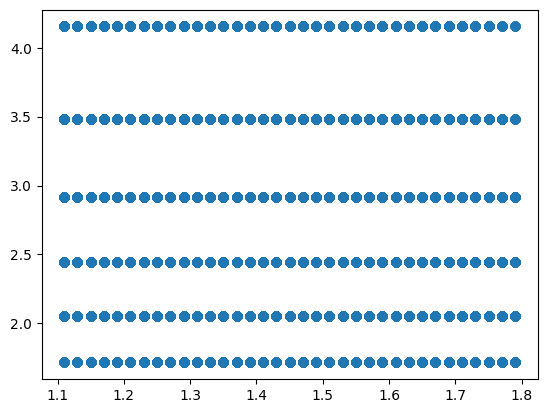

In [56]:
plt.scatter(df[df.Ebeam==Ebeam].W, df[df.Ebeam==Ebeam].Q2)

In [57]:
plot_joint_cross_sections(df, 5.754, 1.23, 2.05, -0.1, df_grid)

0 5.754 1.23 2.05 -0.1


ValueError: len(df_grid_instance_set)==0

  0%|          | 0/4 [00:00<?, ?it/s]

0 5.754 1.23 1.715 -0.9
5.754 1.23 1.715 -0.9
0 5.754 1.23 1.715 -0.8
5.754 1.23 1.715 -0.8
0 5.754 1.23 1.715 -0.7
5.754 1.23 1.715 -0.7
0 5.754 1.23 1.715 -0.6
5.754 1.23 1.715 -0.6


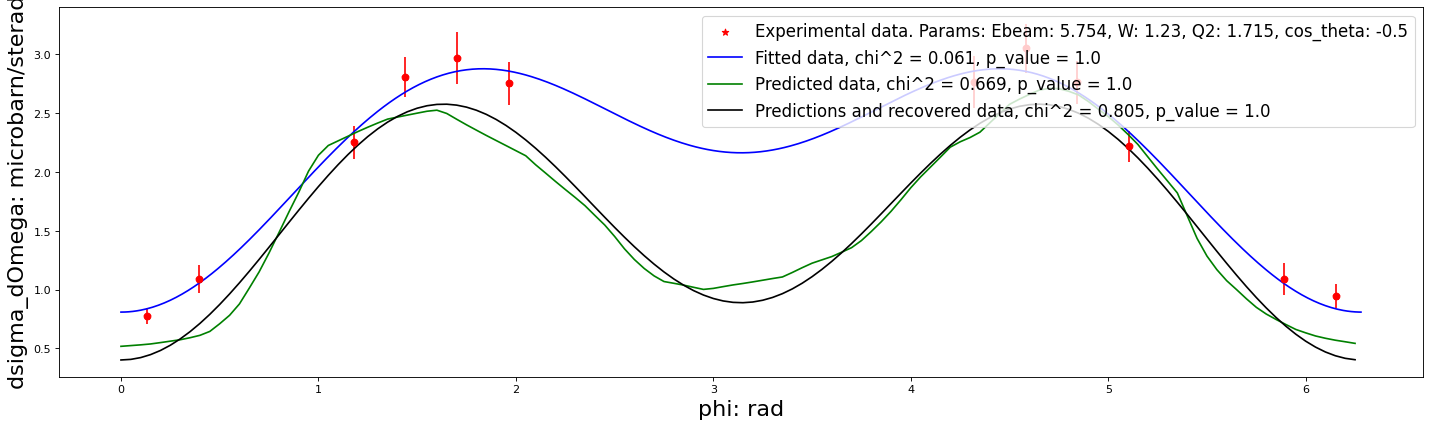

0 5.754 1.23 1.715 -0.4
5.754 1.23 1.715 -0.4


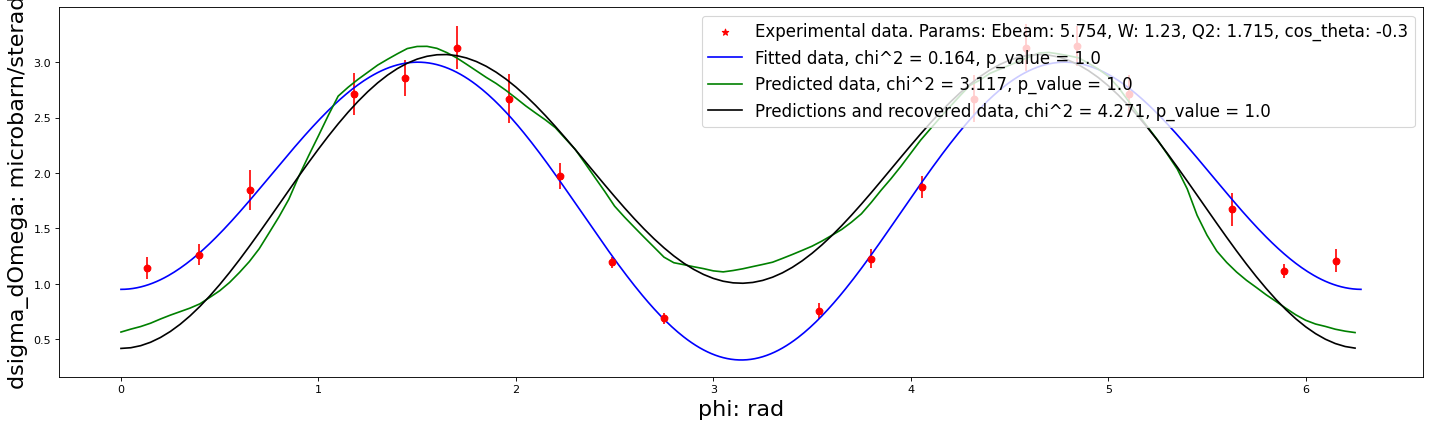

0 5.754 1.23 1.715 -0.2
5.754 1.23 1.715 -0.2


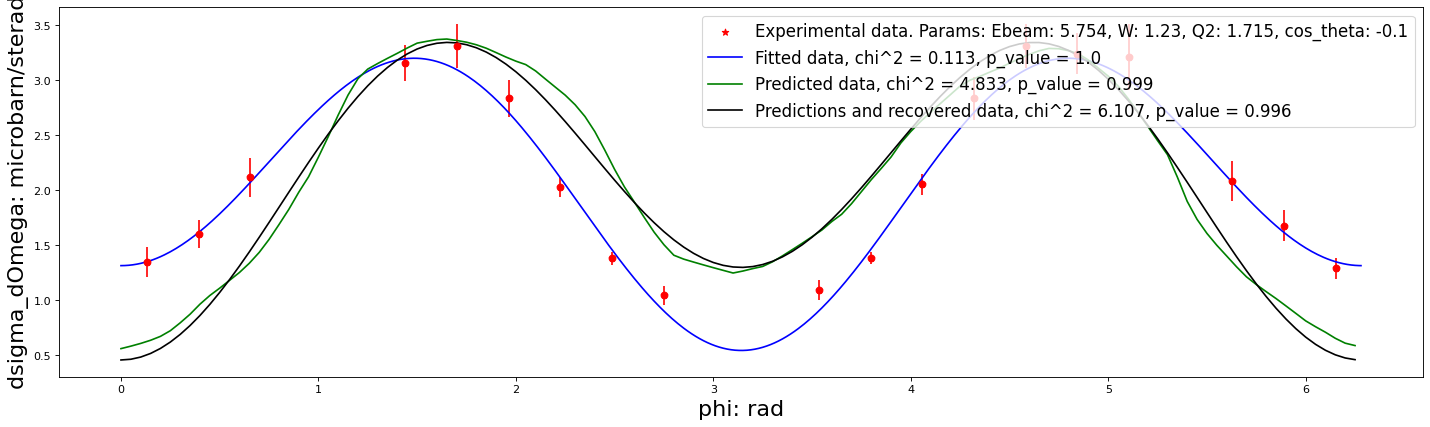

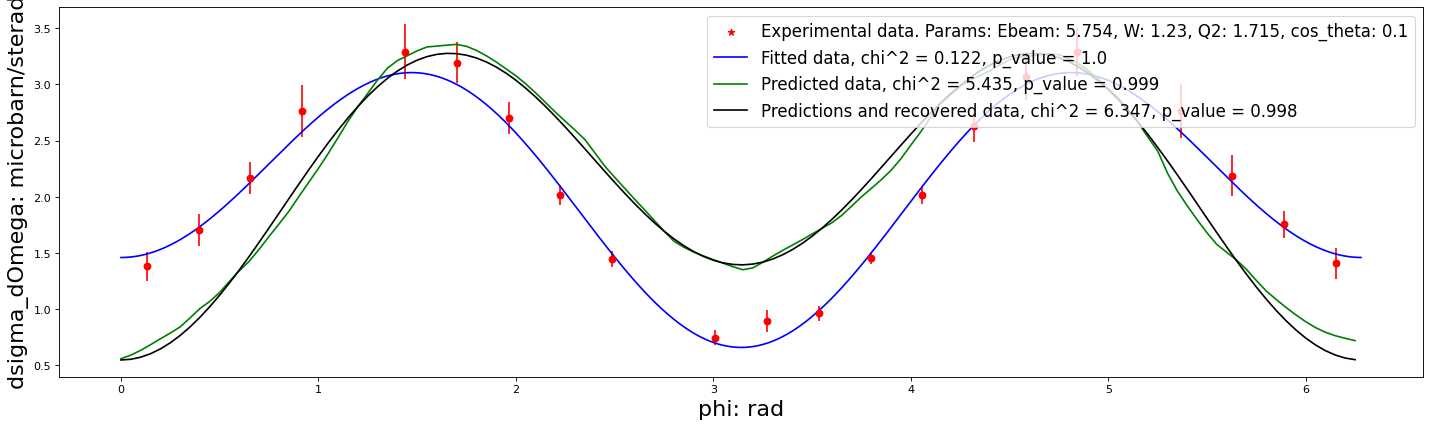

0 5.754 1.23 1.715 0.2
5.754 1.23 1.715 0.2


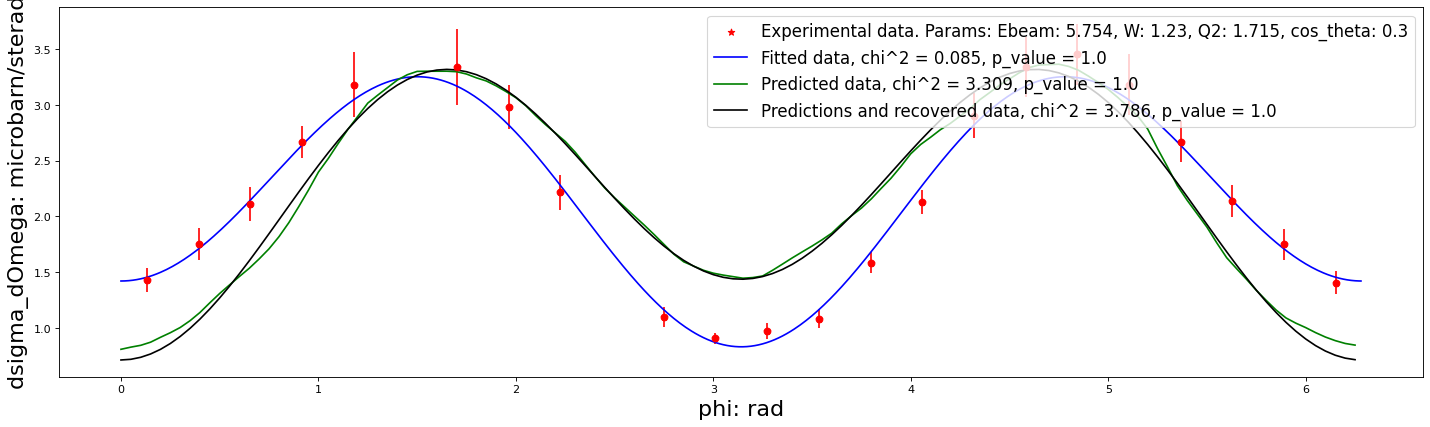

0 5.754 1.23 1.715 0.4
5.754 1.23 1.715 0.4


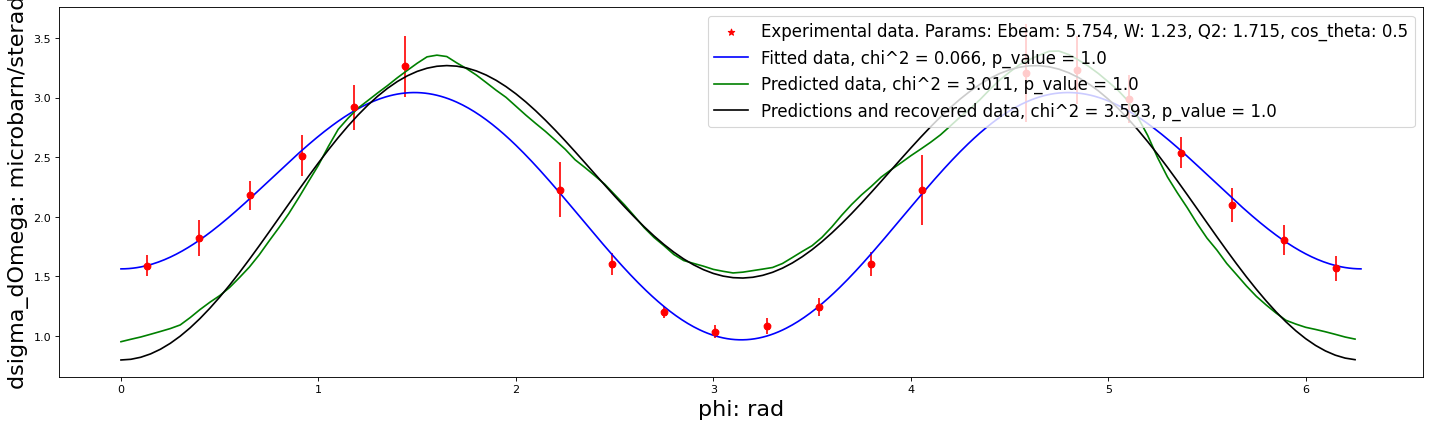

0 5.754 1.23 1.715 0.6
5.754 1.23 1.715 0.6


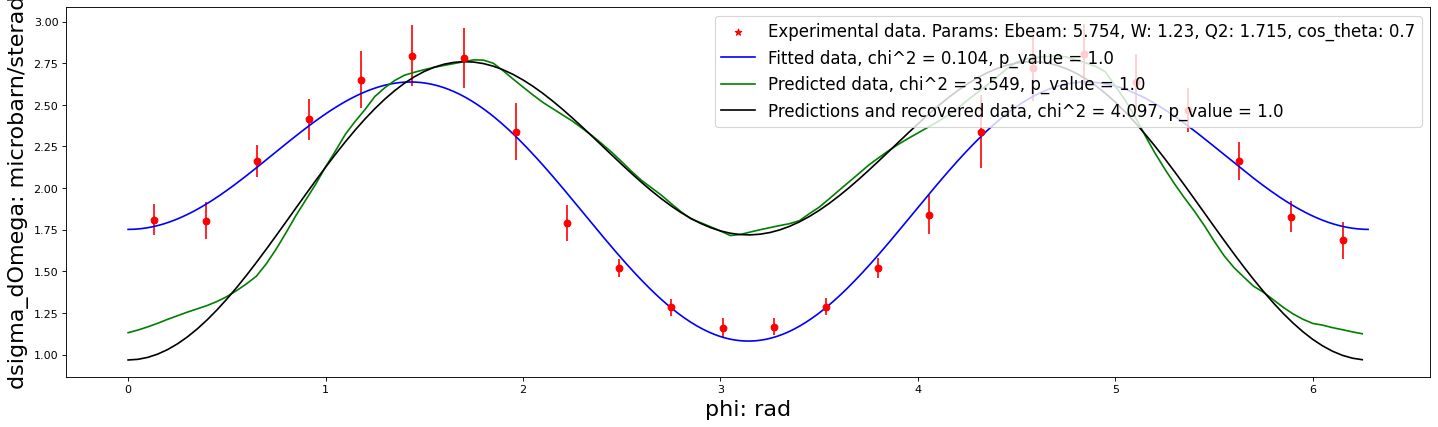

0 5.754 1.23 1.715 0.8
5.754 1.23 1.715 0.8


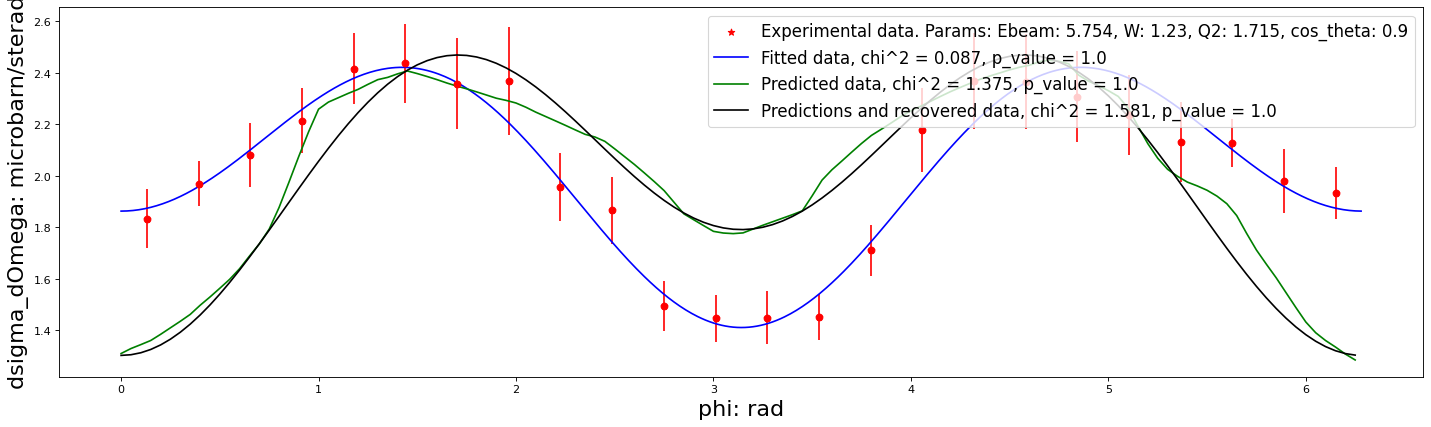


 25%|██▌       | 1/4 [00:02<00:06,  2.21s/it]

5.754 1.53 1.715 -0.9
0 5.754 1.53 1.715 -0.8
5.754 1.53 1.715 -0.8


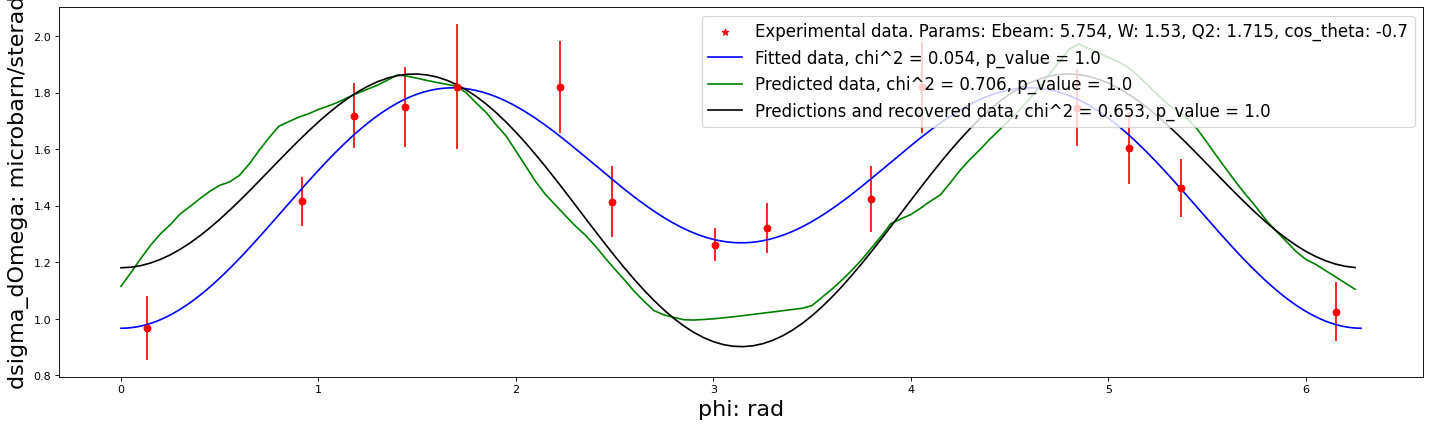

0 5.754 1.53 1.715 -0.6
5.754 1.53 1.715 -0.6


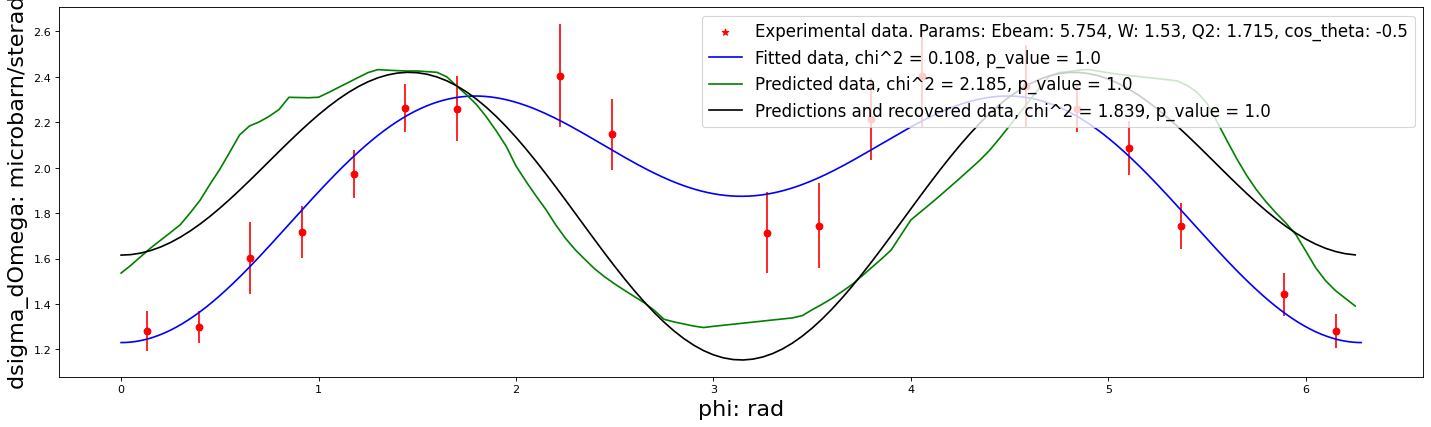

0 5.754 1.53 1.715 -0.4
5.754 1.53 1.715 -0.4


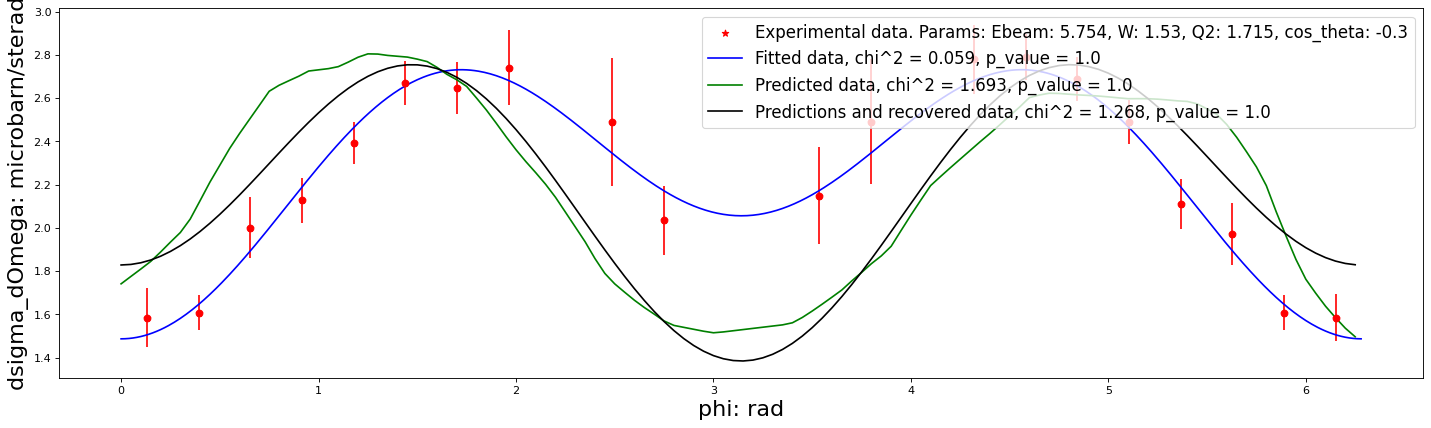

0 5.754 1.53 1.715 -0.2
5.754 1.53 1.715 -0.2


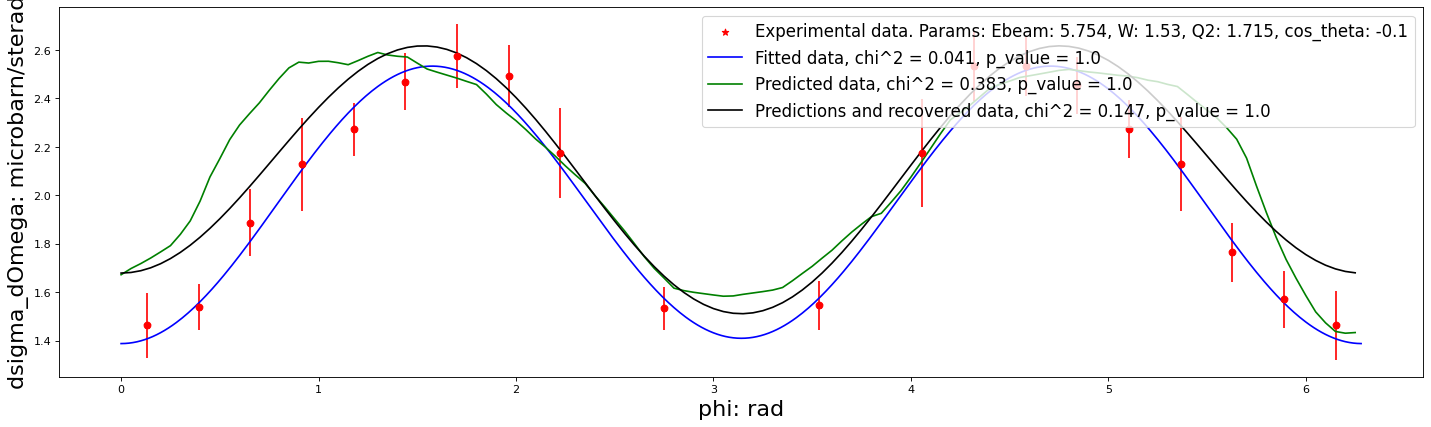

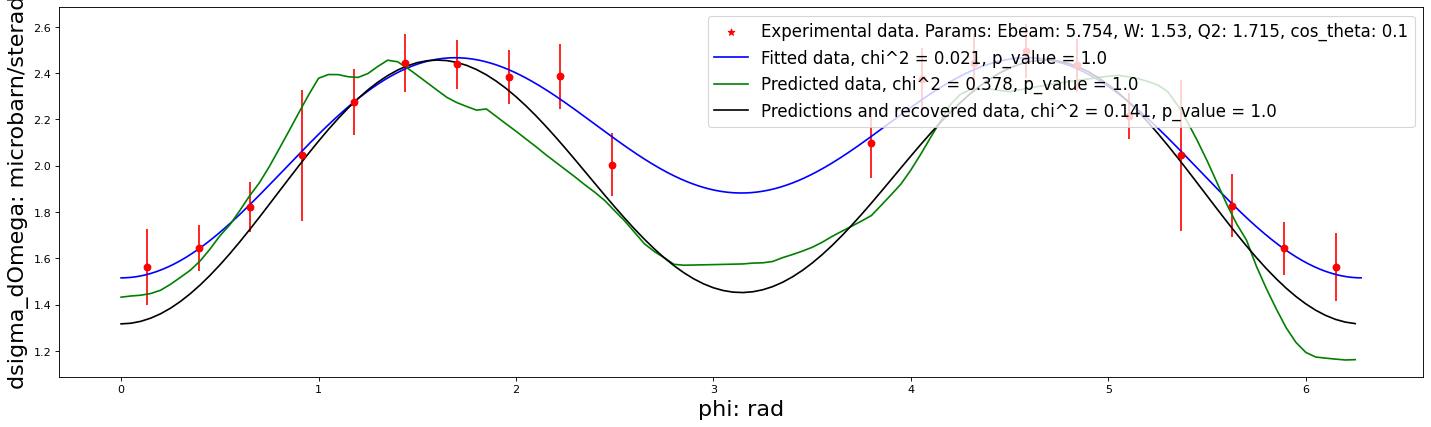

0 5.754 1.53 1.715 0.2
5.754 1.53 1.715 0.2


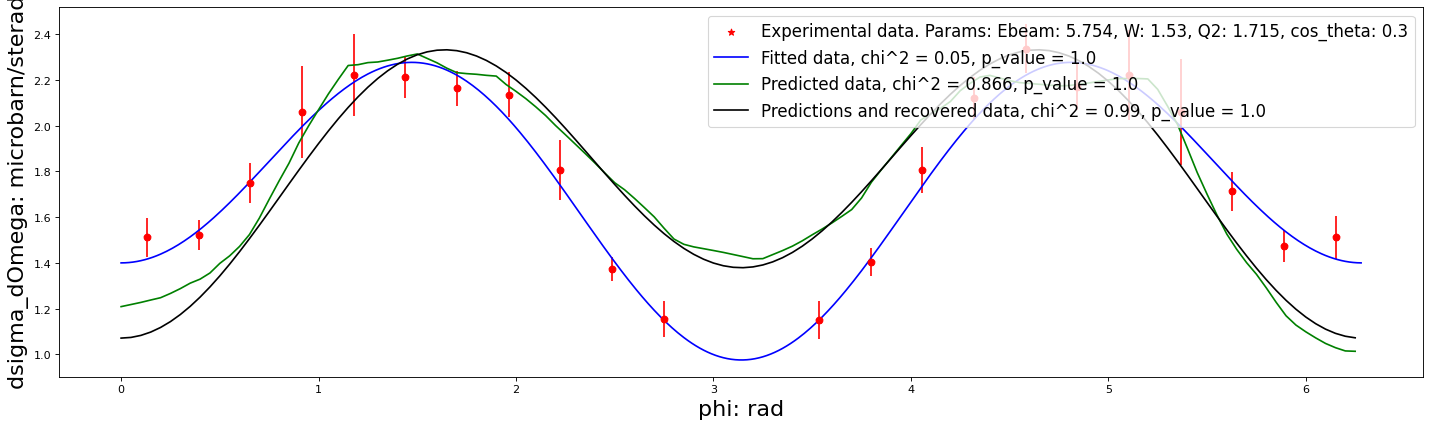

0 5.754 1.53 1.715 0.4
5.754 1.53 1.715 0.4


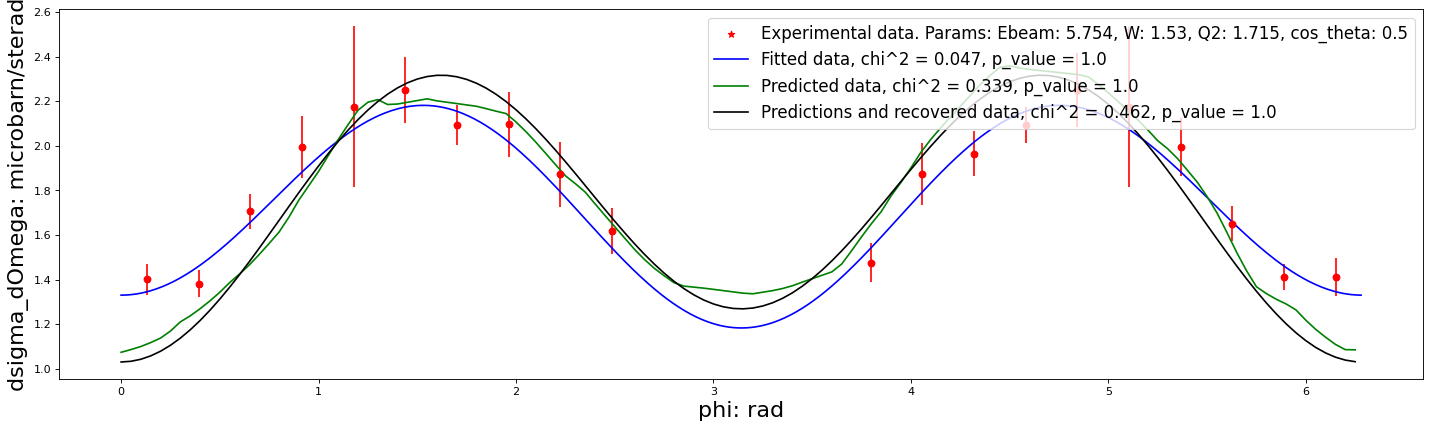

0 5.754 1.53 1.715 0.6
5.754 1.53 1.715 0.6


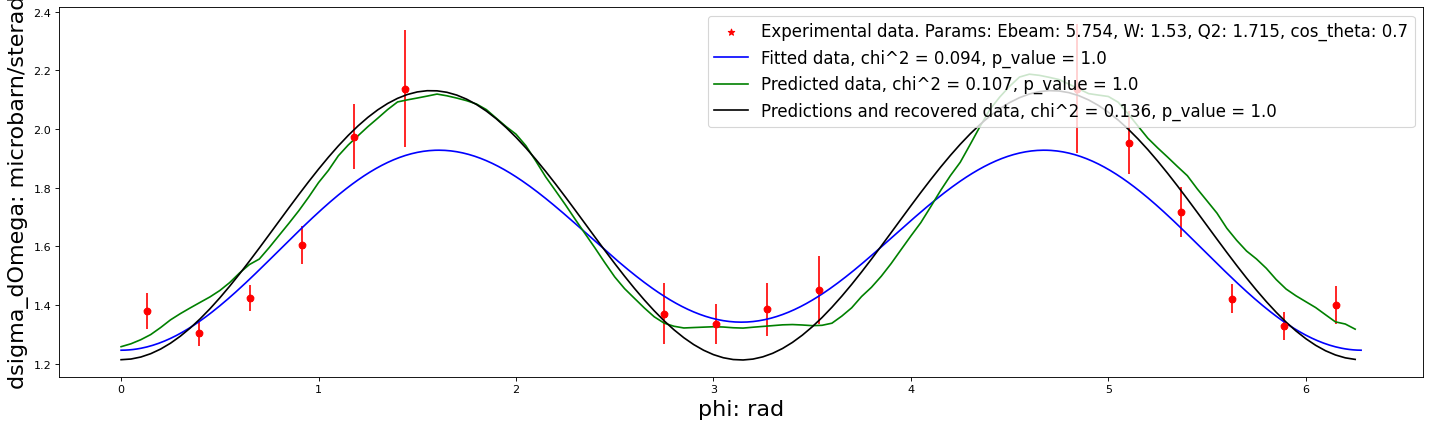

0 5.754 1.53 1.715 0.8
5.754 1.53 1.715 0.8


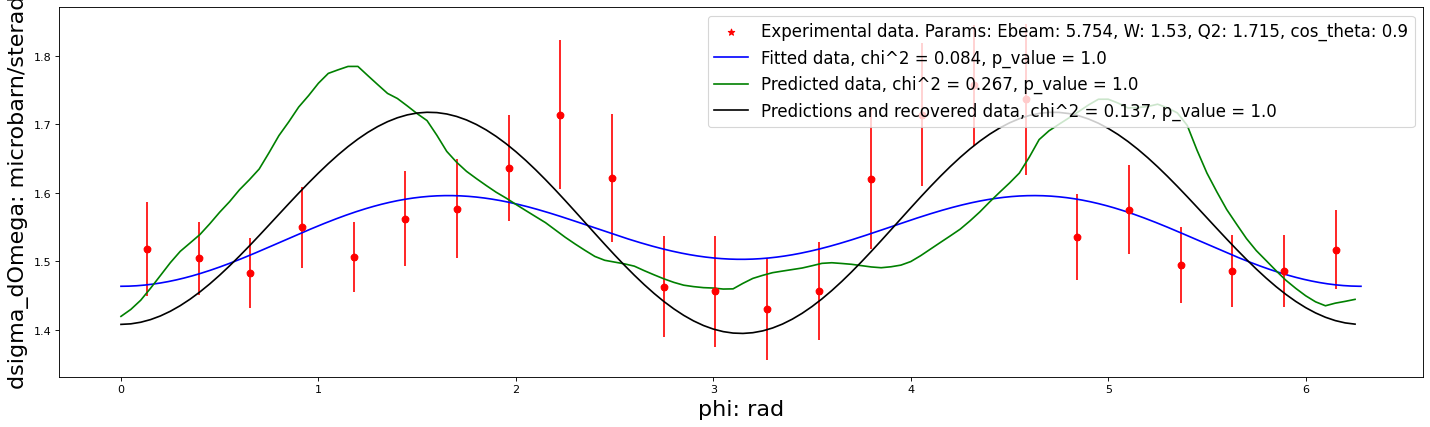


 50%|█████     | 2/4 [00:04<00:04,  2.19s/it]

0 5.754 1.715 1.715 -0.9
5.754 1.715 1.715 -0.9
0 5.754 1.715 1.715 -0.8
5.754 1.715 1.715 -0.8
0 5.754 1.715 1.715 -0.7
5.754 1.715 1.715 -0.7
0 5.754 1.715 1.715 -0.6
5.754 1.715 1.715 -0.6
0 5.754 1.715 1.715 -0.5
5.754 1.715 1.715 -0.5
0 5.754 1.715 1.715 -0.4
5.754 1.715 1.715 -0.4
0 5.754 1.715 1.715 -0.3
5.754 1.715 1.715 -0.3
0 5.754 1.715 1.715 -0.2
5.754 1.715 1.715 -0.2
0 5.754 1.715 1.715 -0.1
5.754 1.715 1.715 -0.1
0 5.754 1.715 1.715 0.1
5.754 1.715 1.715 0.1



 75%|███████▌  | 3/4 [00:04<00:01,  1.37s/it]

0 5.754 1.715 1.715 0.2
5.754 1.715 1.715 0.2
0 5.754 1.715 1.715 0.3
5.754 1.715 1.715 0.3
0 5.754 1.715 1.715 0.4
5.754 1.715 1.715 0.4
0 5.754 1.715 1.715 0.5
5.754 1.715 1.715 0.5
0 5.754 1.715 1.715 0.6
5.754 1.715 1.715 0.6
0 5.754 1.715 1.715 0.7
5.754 1.715 1.715 0.7
0 5.754 1.715 1.715 0.8
5.754 1.715 1.715 0.8
0 5.754 1.715 1.715 0.9
5.754 1.715 1.715 0.9
0 5.754 1.95 1.715 -0.9
5.754 1.95 1.715 -0.9
0 5.754 1.95 1.715 -0.8
5.754 1.95 1.715 -0.8
0 5.754 1.95 1.715 -0.7
5.754 1.95 1.715 -0.7
0 5.754 1.95 1.715 -0.6
5.754 1.95 1.715 -0.6
0 5.754 1.95 1.715 -0.5
5.754 1.95 1.715 -0.5
0 5.754 1.95 1.715 -0.4
5.754 1.95 1.715 -0.4
0 5.754 1.95 1.715 -0.3
5.754 1.95 1.715 -0.3
0 5.754 1.95 1.715 -0.2
5.754 1.95 1.715 -0.2
0 5.754 1.95 1.715 -0.1
5.754 1.95 1.715 -0.1
0 5.754 1.95 1.715 0.1
5.754 1.95 1.715 0.1
0 5.754 1.95 1.715 0.2
5.754 1.95 1.715 0.2
0 5.754 1.95 1.715 0.3
5.754 1.95 1.715 0.3



 17%|█▋        | 1/6 [00:05<00:25,  5.17s/it]

0 5.754 1.95 1.715 0.4
5.754 1.95 1.715 0.4
0 5.754 1.95 1.715 0.5
5.754 1.95 1.715 0.5
0 5.754 1.95 1.715 0.6
5.754 1.95 1.715 0.6
0 5.754 1.95 1.715 0.7
5.754 1.95 1.715 0.7
0 5.754 1.95 1.715 0.8
5.754 1.95 1.715 0.8
0 5.754 1.95 1.715 0.9
5.754 1.95 1.715 0.9



  0%|          | 0/4 [00:00<?, ?it/s]

0 5.754 1.23 2.05 -0.9
5.754 1.23 2.05 -0.9
0 5.754 1.23 2.05 -0.8
5.754 1.23 2.05 -0.8
0 5.754 1.23 2.05 -0.7
5.754 1.23 2.05 -0.7
0 5.754 1.23 2.05 -0.6
5.754 1.23 2.05 -0.6
0 5.754 1.23 2.05 -0.5
5.754 1.23 2.05 -0.5
0 5.754 1.23 2.05 -0.4
5.754 1.23 2.05 -0.4
0 5.754 1.23 2.05 -0.3
5.754 1.23 2.05 -0.3
0 5.754 1.23 2.05 -0.2
5.754 1.23 2.05 -0.2
0 5.754 1.23 2.05 -0.1
5.754 1.23 2.05 -0.1
0 5.754 1.23 2.05 0.1
5.754 1.23 2.05 0.1
0 5.754 1.23 2.05 0.2
5.754 1.23 2.05 0.2
0 5.754 1.23 2.05 0.3
5.754 1.23 2.05 0.3
0 5.754 1.23 2.05 0.4
5.754 1.23 2.05 0.4
0 5.754 1.23 2.05 0.5
5.754 1.23 2.05 0.5



 25%|██▌       | 1/4 [00:00<00:01,  2.57it/s]

0 5.754 1.23 2.05 0.6
5.754 1.23 2.05 0.6
0 5.754 1.23 2.05 0.7
5.754 1.23 2.05 0.7
0 5.754 1.23 2.05 0.8
5.754 1.23 2.05 0.8
0 5.754 1.23 2.05 0.9
5.754 1.23 2.05 0.9
0 5.754 1.53 2.05 -0.9
5.754 1.53 2.05 -0.9
0 5.754 1.53 2.05 -0.8
5.754 1.53 2.05 -0.8
0 5.754 1.53 2.05 -0.7
5.754 1.53 2.05 -0.7
0 5.754 1.53 2.05 -0.6
5.754 1.53 2.05 -0.6
0 5.754 1.53 2.05 -0.5
5.754 1.53 2.05 -0.5
0 5.754 1.53 2.05 -0.4
5.754 1.53 2.05 -0.4
0 5.754 1.53 2.05 -0.3
5.754 1.53 2.05 -0.3
0 5.754 1.53 2.05 -0.2
5.754 1.53 2.05 -0.2
0 5.754 1.53 2.05 -0.1
5.754 1.53 2.05 -0.1
0 5.754 1.53 2.05 0.1
5.754 1.53 2.05 0.1
0 5.754 1.53 2.05 0.2
5.754 1.53 2.05 0.2
0 5.754 1.53 2.05 0.3
5.754 1.53 2.05 0.3
0 5.754 1.53 2.05 0.4
5.754 1.53 2.05 0.4
0 5.754 1.53 2.05 0.5
5.754 1.53 2.05 0.5
0 5.754 1.53 2.05 0.6
5.754 1.53 2.05 0.6
0 5.754 1.53 2.05 0.7
5.754 1.53 2.05 0.7



 50%|█████     | 2/4 [00:00<00:00,  2.58it/s]

0 5.754 1.53 2.05 0.8
5.754 1.53 2.05 0.8
0 5.754 1.53 2.05 0.9
5.754 1.53 2.05 0.9
0 5.754 1.715 2.05 -0.9
5.754 1.715 2.05 -0.9
0 5.754 1.715 2.05 -0.8
5.754 1.715 2.05 -0.8
0 5.754 1.715 2.05 -0.7
5.754 1.715 2.05 -0.7
0 5.754 1.715 2.05 -0.6
5.754 1.715 2.05 -0.6
0 5.754 1.715 2.05 -0.5
5.754 1.715 2.05 -0.5
0 5.754 1.715 2.05 -0.4
5.754 1.715 2.05 -0.4
0 5.754 1.715 2.05 -0.3
5.754 1.715 2.05 -0.3
0 5.754 1.715 2.05 -0.2
5.754 1.715 2.05 -0.2
0 5.754 1.715 2.05 -0.1
5.754 1.715 2.05 -0.1
0 5.754 1.715 2.05 0.1
5.754 1.715 2.05 0.1
0 5.754 1.715 2.05 0.2
5.754 1.715 2.05 0.2
0 5.754 1.715 2.05 0.3
5.754 1.715 2.05 0.3
0 5.754 1.715 2.05 0.4
5.754 1.715 2.05 0.4
0 5.754 1.715 2.05 0.5
5.754 1.715 2.05 0.5
0 5.754 1.715 2.05 0.6
5.754 1.715 2.05 0.6
0 5.754 1.715 2.05 0.7
5.754 1.715 2.05 0.7
0 5.754 1.715 2.05 0.8
5.754 1.715 2.05 0.8



 75%|███████▌  | 3/4 [00:01<00:00,  2.57it/s]

0 5.754 1.715 2.05 0.9
5.754 1.715 2.05 0.9
0 5.754 1.95 2.05 -0.9
5.754 1.95 2.05 -0.9
0 5.754 1.95 2.05 -0.8
5.754 1.95 2.05 -0.8
0 5.754 1.95 2.05 -0.7
5.754 1.95 2.05 -0.7
0 5.754 1.95 2.05 -0.6
5.754 1.95 2.05 -0.6
0 5.754 1.95 2.05 -0.5
5.754 1.95 2.05 -0.5
0 5.754 1.95 2.05 -0.4
5.754 1.95 2.05 -0.4
0 5.754 1.95 2.05 -0.3
5.754 1.95 2.05 -0.3
0 5.754 1.95 2.05 -0.2
5.754 1.95 2.05 -0.2
0 5.754 1.95 2.05 -0.1
5.754 1.95 2.05 -0.1
0 5.754 1.95 2.05 0.1
5.754 1.95 2.05 0.1
0 5.754 1.95 2.05 0.2
5.754 1.95 2.05 0.2
0 5.754 1.95 2.05 0.3
5.754 1.95 2.05 0.3
0 5.754 1.95 2.05 0.4
5.754 1.95 2.05 0.4
0 5.754 1.95 2.05 0.5
5.754 1.95 2.05 0.5
0 5.754 1.95 2.05 0.6
5.754 1.95 2.05 0.6



 33%|███▎      | 2/6 [00:06<00:12,  3.05s/it]

0 5.754 1.95 2.05 0.7
5.754 1.95 2.05 0.7
0 5.754 1.95 2.05 0.8
5.754 1.95 2.05 0.8
0 5.754 1.95 2.05 0.9
5.754 1.95 2.05 0.9



  0%|          | 0/4 [00:00<?, ?it/s]

0 5.754 1.23 2.445 -0.9
5.754 1.23 2.445 -0.9
0 5.754 1.23 2.445 -0.8
5.754 1.23 2.445 -0.8
0 5.754 1.23 2.445 -0.7
5.754 1.23 2.445 -0.7
0 5.754 1.23 2.445 -0.6
5.754 1.23 2.445 -0.6
0 5.754 1.23 2.445 -0.5
5.754 1.23 2.445 -0.5
0 5.754 1.23 2.445 -0.4
5.754 1.23 2.445 -0.4
0 5.754 1.23 2.445 -0.3
5.754 1.23 2.445 -0.3
0 5.754 1.23 2.445 -0.2
5.754 1.23 2.445 -0.2
0 5.754 1.23 2.445 -0.1
5.754 1.23 2.445 -0.1
0 5.754 1.23 2.445 0.1
5.754 1.23 2.445 0.1
0 5.754 1.23 2.445 0.2
5.754 1.23 2.445 0.2
0 5.754 1.23 2.445 0.3
5.754 1.23 2.445 0.3
0 5.754 1.23 2.445 0.4
5.754 1.23 2.445 0.4
0 5.754 1.23 2.445 0.5
5.754 1.23 2.445 0.5
0 5.754 1.23 2.445 0.6
5.754 1.23 2.445 0.6
0 5.754 1.23 2.445 0.7
5.754 1.23 2.445 0.7



 25%|██▌       | 1/4 [00:00<00:01,  2.56it/s]

0 5.754 1.23 2.445 0.8
5.754 1.23 2.445 0.8
0 5.754 1.23 2.445 0.9
5.754 1.23 2.445 0.9
0 5.754 1.53 2.445 -0.9
5.754 1.53 2.445 -0.9
0 5.754 1.53 2.445 -0.8
5.754 1.53 2.445 -0.8
0 5.754 1.53 2.445 -0.7
5.754 1.53 2.445 -0.7
0 5.754 1.53 2.445 -0.6
5.754 1.53 2.445 -0.6
0 5.754 1.53 2.445 -0.5
5.754 1.53 2.445 -0.5
0 5.754 1.53 2.445 -0.4
5.754 1.53 2.445 -0.4
0 5.754 1.53 2.445 -0.3
5.754 1.53 2.445 -0.3
0 5.754 1.53 2.445 -0.2
5.754 1.53 2.445 -0.2
0 5.754 1.53 2.445 -0.1
5.754 1.53 2.445 -0.1
0 5.754 1.53 2.445 0.1
5.754 1.53 2.445 0.1
0 5.754 1.53 2.445 0.2
5.754 1.53 2.445 0.2
0 5.754 1.53 2.445 0.3
5.754 1.53 2.445 0.3



 50%|█████     | 2/4 [00:00<00:00,  2.54it/s]

0 5.754 1.53 2.445 0.4
5.754 1.53 2.445 0.4
0 5.754 1.53 2.445 0.5
5.754 1.53 2.445 0.5
0 5.754 1.53 2.445 0.6
5.754 1.53 2.445 0.6
0 5.754 1.53 2.445 0.7
5.754 1.53 2.445 0.7
0 5.754 1.53 2.445 0.8
5.754 1.53 2.445 0.8
0 5.754 1.53 2.445 0.9
5.754 1.53 2.445 0.9
0 5.754 1.715 2.445 -0.9
5.754 1.715 2.445 -0.9
0 5.754 1.715 2.445 -0.8
5.754 1.715 2.445 -0.8
0 5.754 1.715 2.445 -0.7
5.754 1.715 2.445 -0.7
0 5.754 1.715 2.445 -0.6
5.754 1.715 2.445 -0.6
0 5.754 1.715 2.445 -0.5
5.754 1.715 2.445 -0.5
0 5.754 1.715 2.445 -0.4
5.754 1.715 2.445 -0.4
0 5.754 1.715 2.445 -0.3
5.754 1.715 2.445 -0.3
0 5.754 1.715 2.445 -0.2
5.754 1.715 2.445 -0.2
0 5.754 1.715 2.445 -0.1
5.754 1.715 2.445 -0.1
0 5.754 1.715 2.445 0.1
5.754 1.715 2.445 0.1
0 5.754 1.715 2.445 0.2
5.754 1.715 2.445 0.2
0 5.754 1.715 2.445 0.3
5.754 1.715 2.445 0.3
0 5.754 1.715 2.445 0.4
5.754 1.715 2.445 0.4
0 5.754 1.715 2.445 0.5
5.754 1.715 2.445 0.5



 75%|███████▌  | 3/4 [00:01<00:00,  2.56it/s]

0 5.754 1.715 2.445 0.6
5.754 1.715 2.445 0.6
0 5.754 1.715 2.445 0.7
5.754 1.715 2.445 0.7
0 5.754 1.715 2.445 0.8
5.754 1.715 2.445 0.8
0 5.754 1.715 2.445 0.9
5.754 1.715 2.445 0.9
0 5.754 1.95 2.445 -0.9
5.754 1.95 2.445 -0.9
0 5.754 1.95 2.445 -0.8
5.754 1.95 2.445 -0.8
0 5.754 1.95 2.445 -0.7
5.754 1.95 2.445 -0.7
0 5.754 1.95 2.445 -0.6
5.754 1.95 2.445 -0.6
0 5.754 1.95 2.445 -0.5
5.754 1.95 2.445 -0.5
0 5.754 1.95 2.445 -0.4
5.754 1.95 2.445 -0.4
0 5.754 1.95 2.445 -0.3
5.754 1.95 2.445 -0.3
0 5.754 1.95 2.445 -0.2
5.754 1.95 2.445 -0.2
0 5.754 1.95 2.445 -0.1
5.754 1.95 2.445 -0.1
0 5.754 1.95 2.445 0.1
5.754 1.95 2.445 0.1
0 5.754 1.95 2.445 0.2
5.754 1.95 2.445 0.2
0 5.754 1.95 2.445 0.3
5.754 1.95 2.445 0.3
0 5.754 1.95 2.445 0.4
5.754 1.95 2.445 0.4
0 5.754 1.95 2.445 0.5
5.754 1.95 2.445 0.5
0 5.754 1.95 2.445 0.6
5.754 1.95 2.445 0.6
0 5.754 1.95 2.445 0.7
5.754 1.95 2.445 0.7



 50%|█████     | 3/6 [00:08<00:07,  2.38s/it]

0 5.754 1.95 2.445 0.8
5.754 1.95 2.445 0.8
0 5.754 1.95 2.445 0.9
5.754 1.95 2.445 0.9



  0%|          | 0/4 [00:00<?, ?it/s]

0 5.754 1.23 2.915 -0.9
5.754 1.23 2.915 -0.9
0 5.754 1.23 2.915 -0.8
5.754 1.23 2.915 -0.8


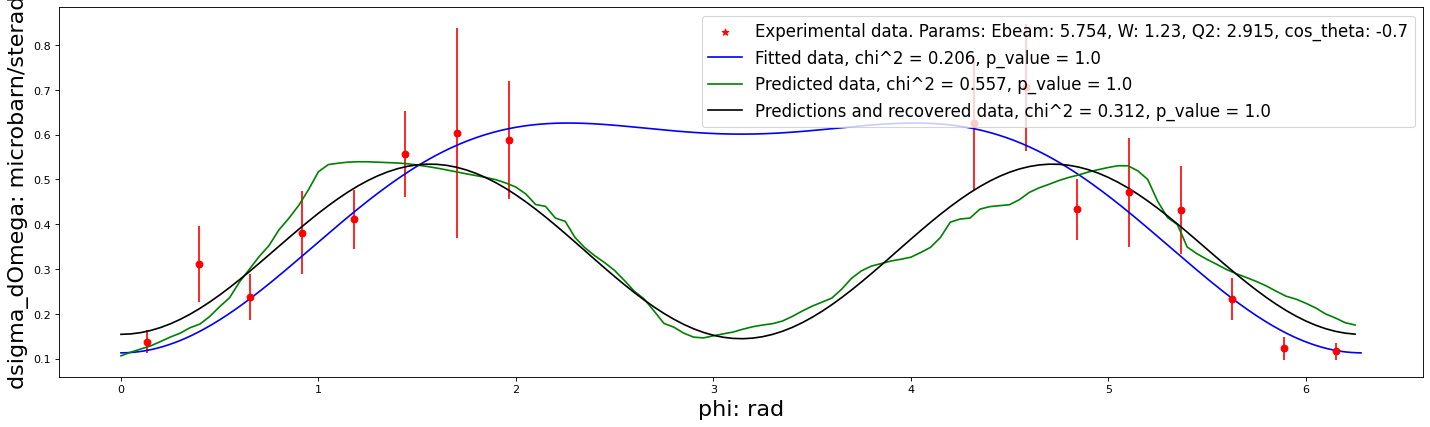

0 5.754 1.23 2.915 -0.6
5.754 1.23 2.915 -0.6


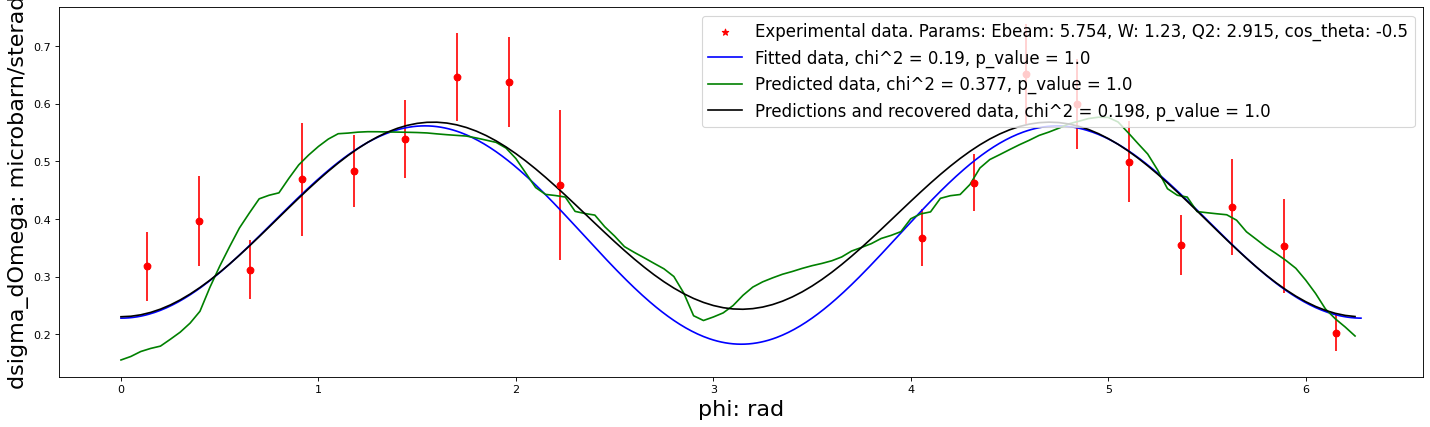

0 5.754 1.23 2.915 -0.4
5.754 1.23 2.915 -0.4


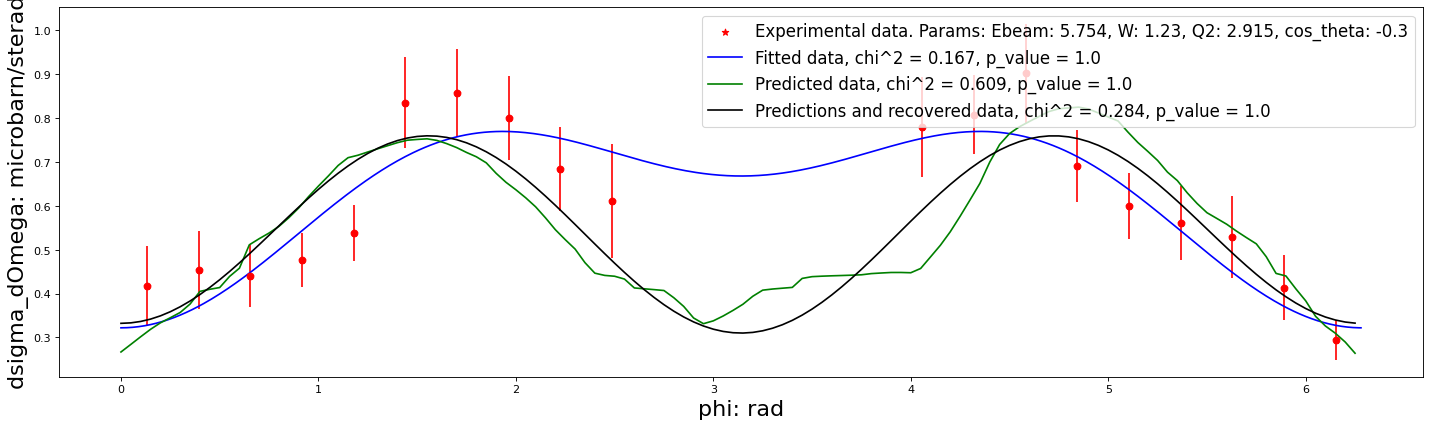

0 5.754 1.23 2.915 -0.2
5.754 1.23 2.915 -0.2


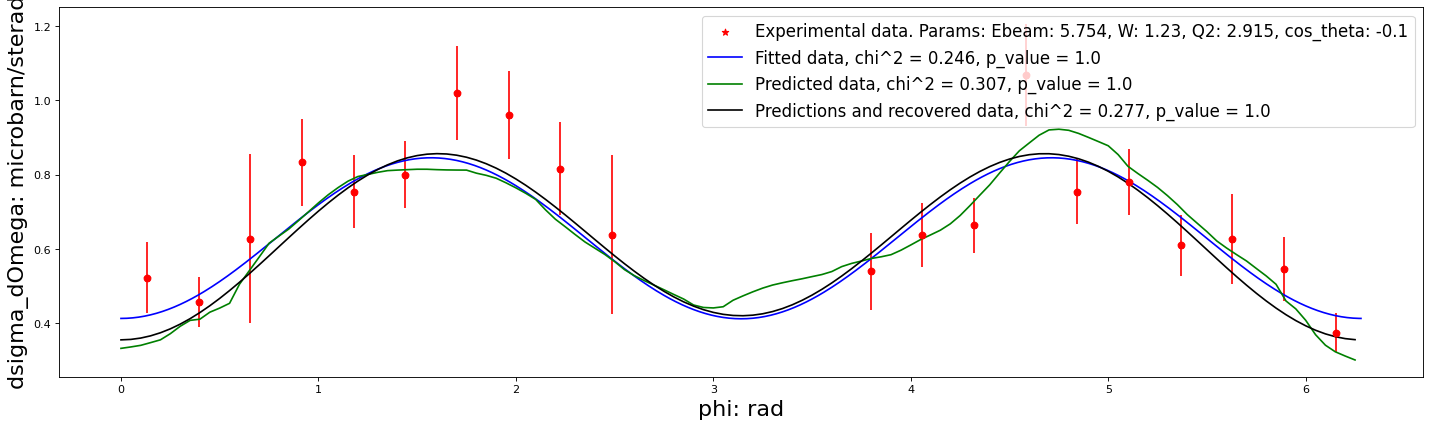

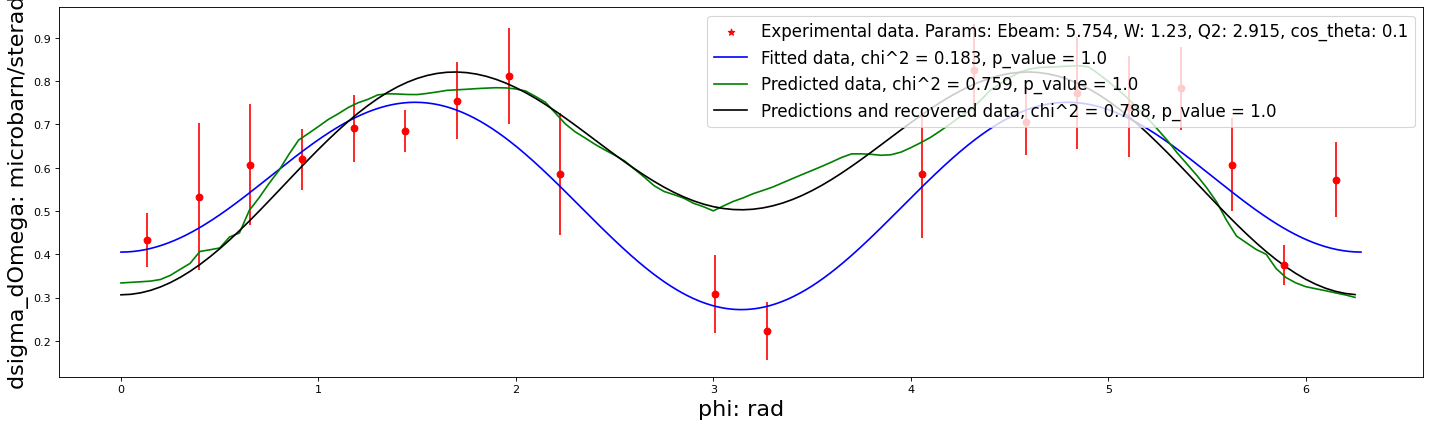

0 5.754 1.23 2.915 0.2
5.754 1.23 2.915 0.2


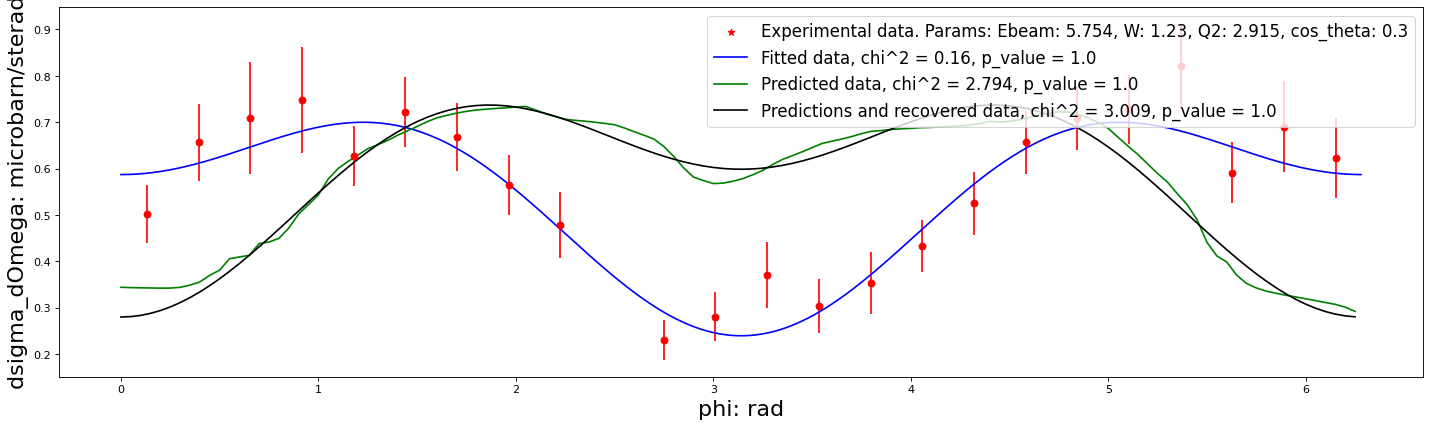

0 5.754 1.23 2.915 0.4
5.754 1.23 2.915 0.4


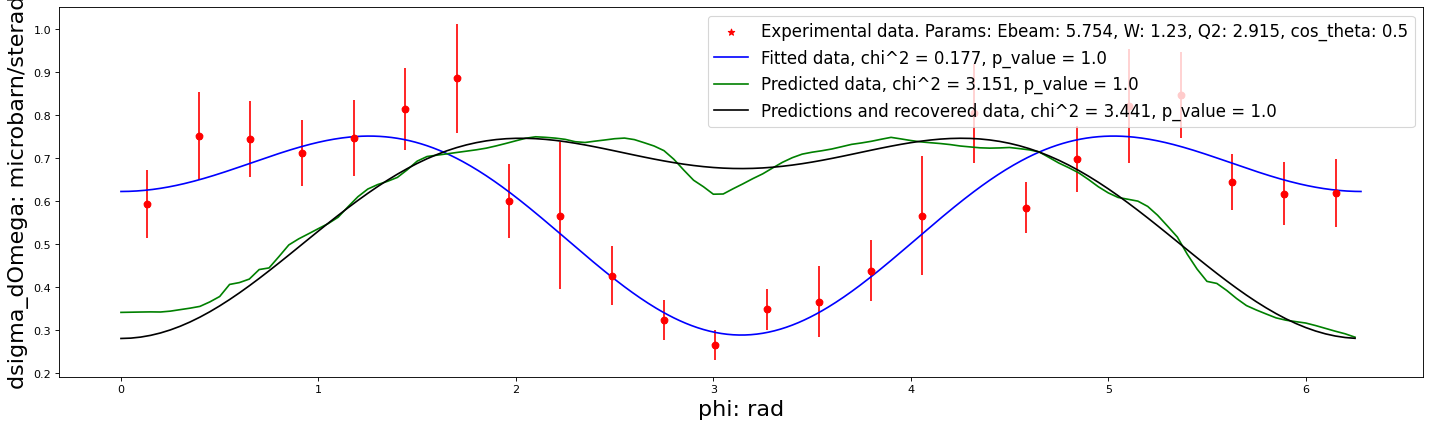

0 5.754 1.23 2.915 0.6
5.754 1.23 2.915 0.6


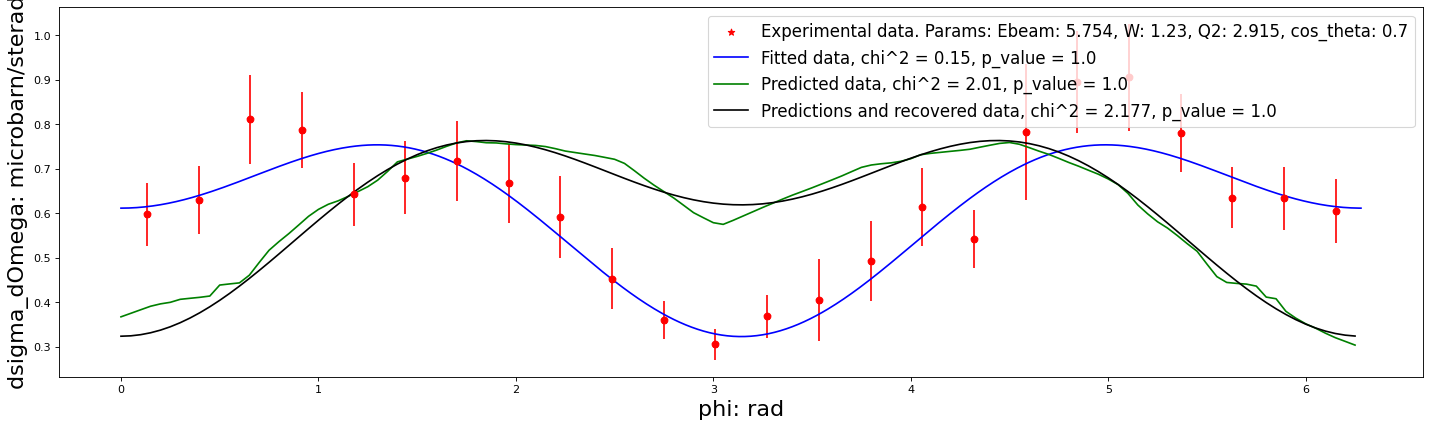

0 5.754 1.23 2.915 0.8
5.754 1.23 2.915 0.8


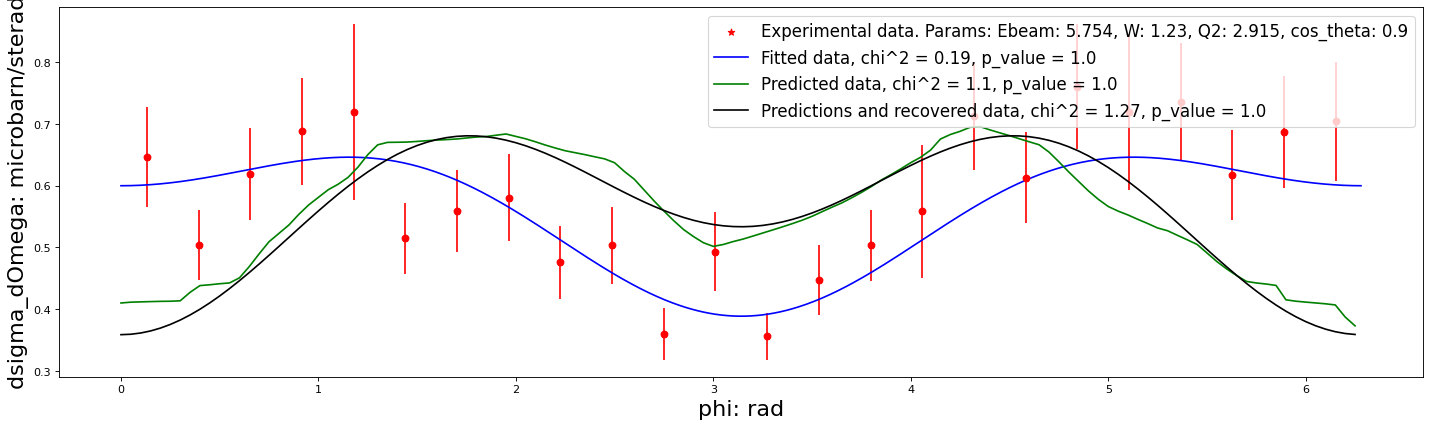


 25%|██▌       | 1/4 [00:02<00:06,  2.13s/it]

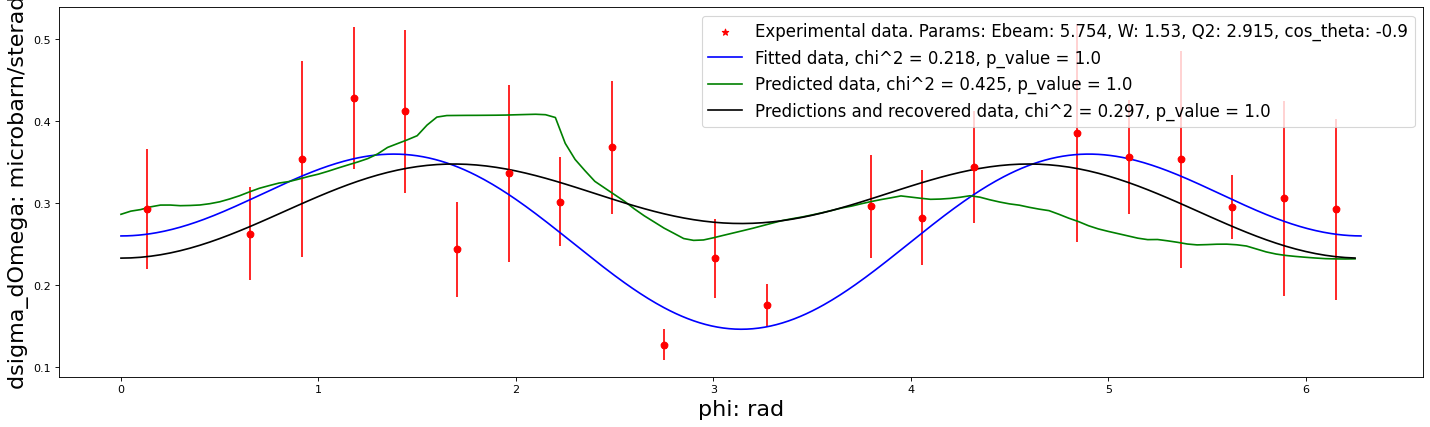

0 5.754 1.53 2.915 -0.8
5.754 1.53 2.915 -0.8


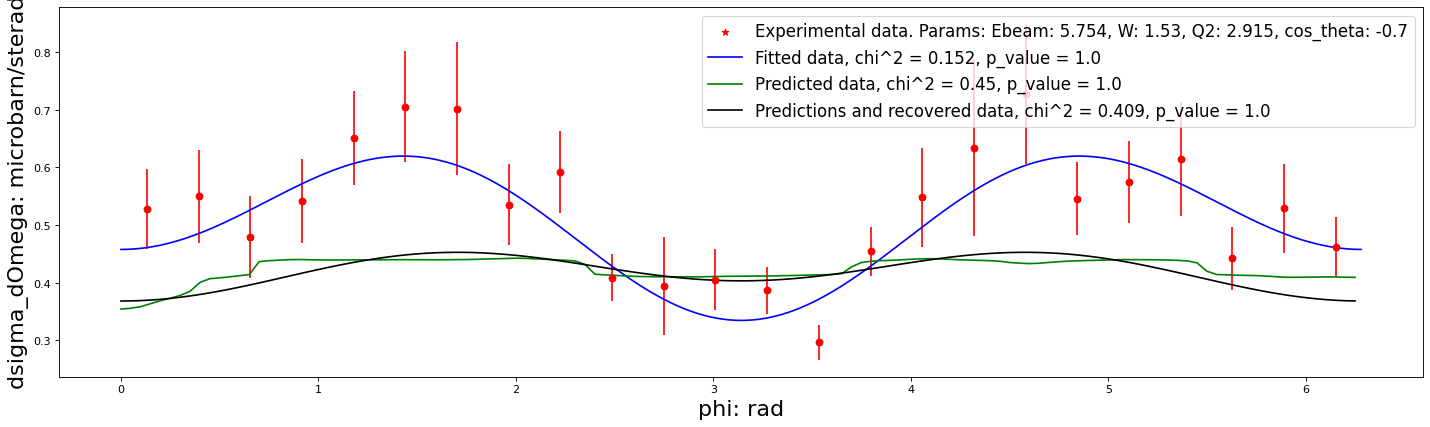

0 5.754 1.53 2.915 -0.6
5.754 1.53 2.915 -0.6


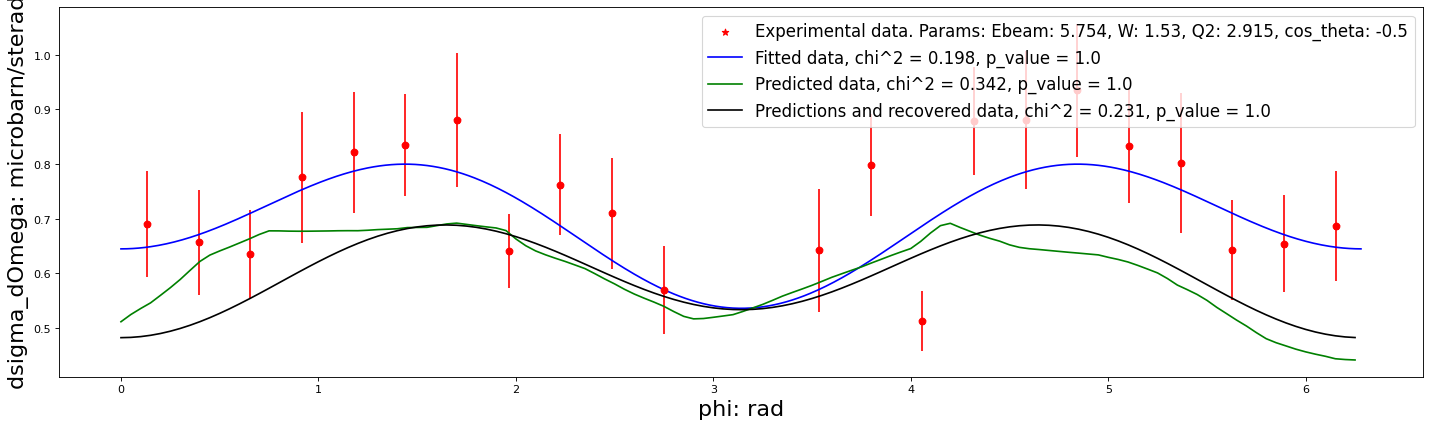

0 5.754 1.53 2.915 -0.4
5.754 1.53 2.915 -0.4


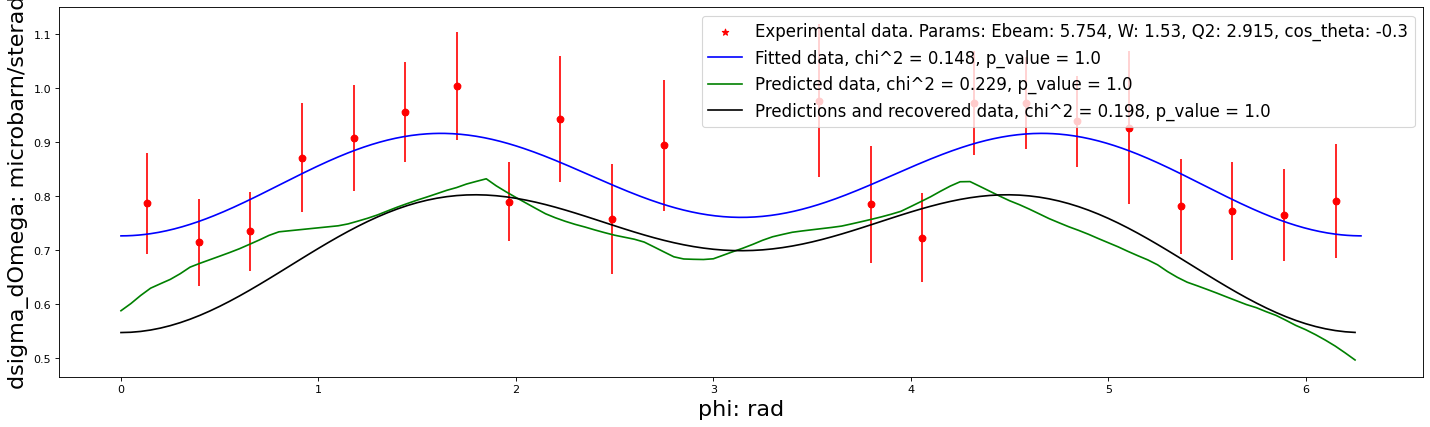

0 5.754 1.53 2.915 -0.2
5.754 1.53 2.915 -0.2


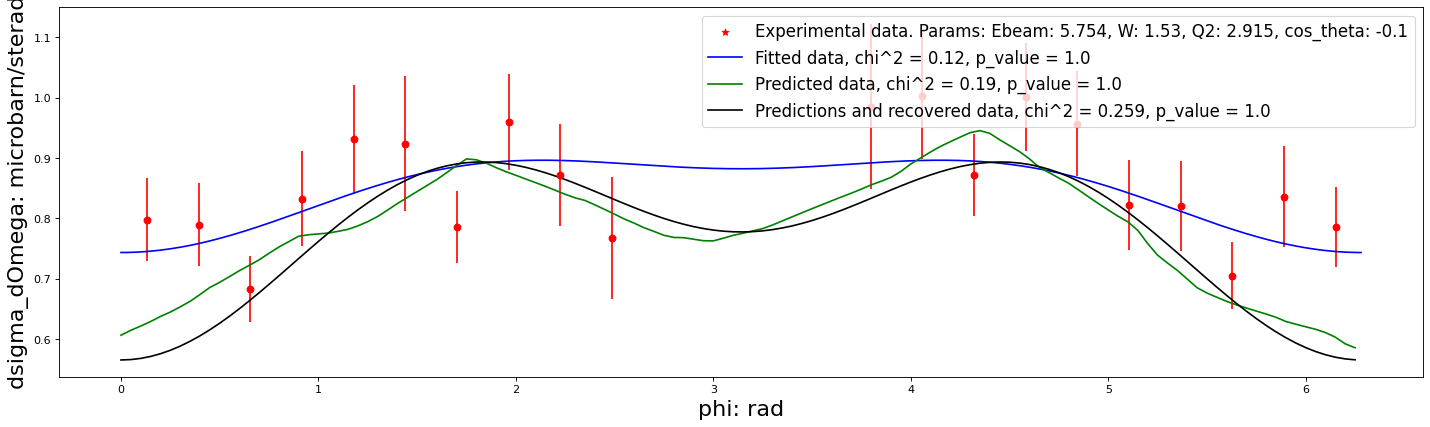

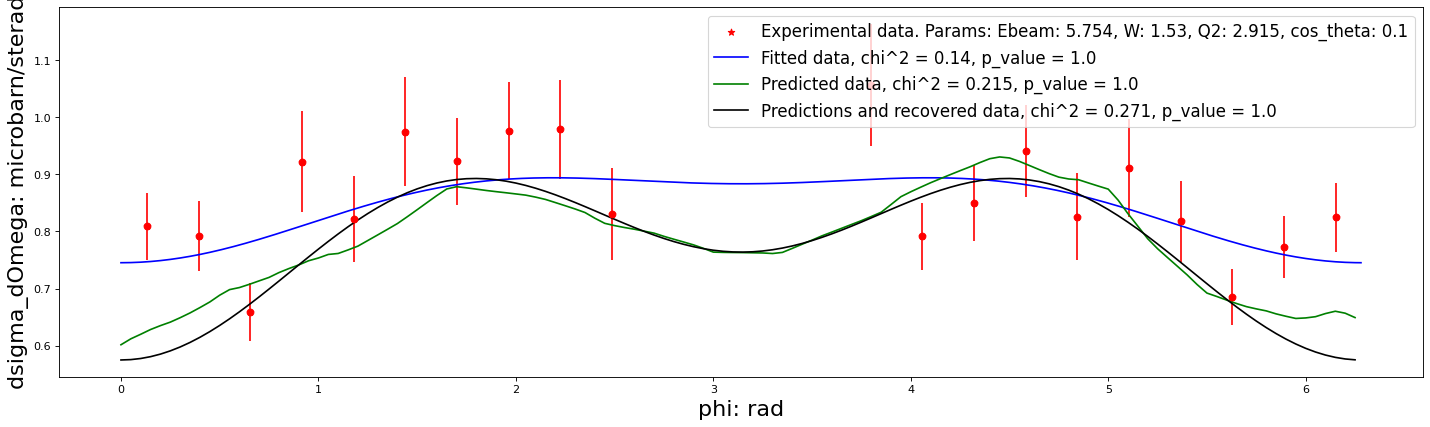

0 5.754 1.53 2.915 0.2
5.754 1.53 2.915 0.2


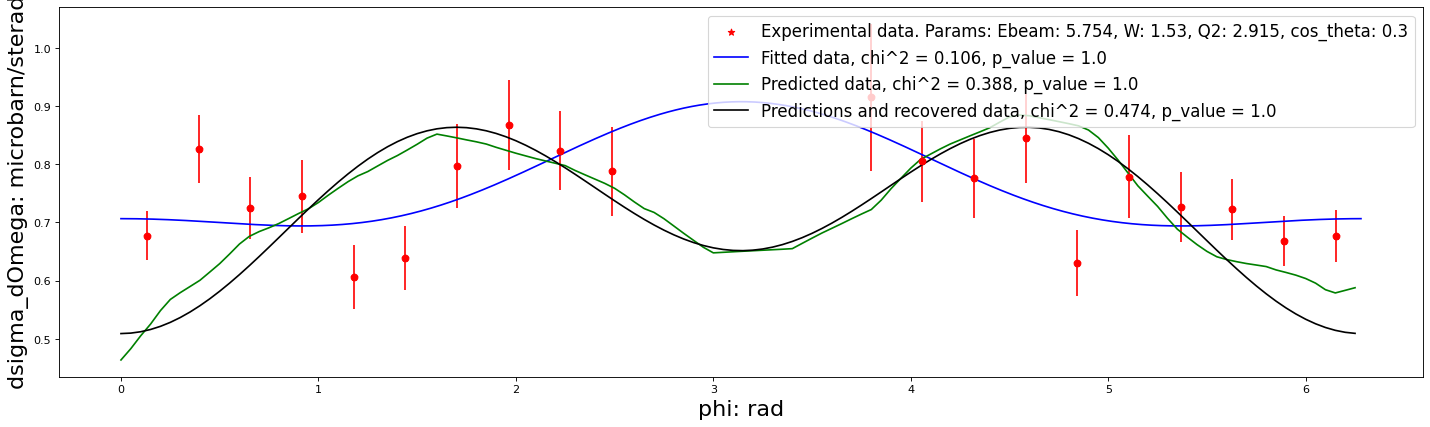

0 5.754 1.53 2.915 0.4
5.754 1.53 2.915 0.4


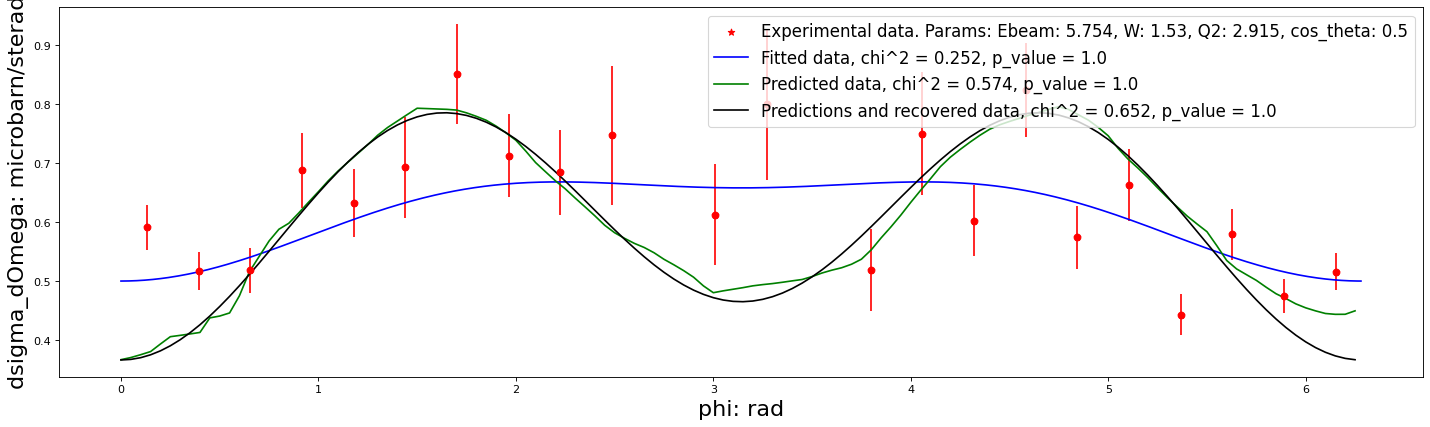

0 5.754 1.53 2.915 0.6
5.754 1.53 2.915 0.6


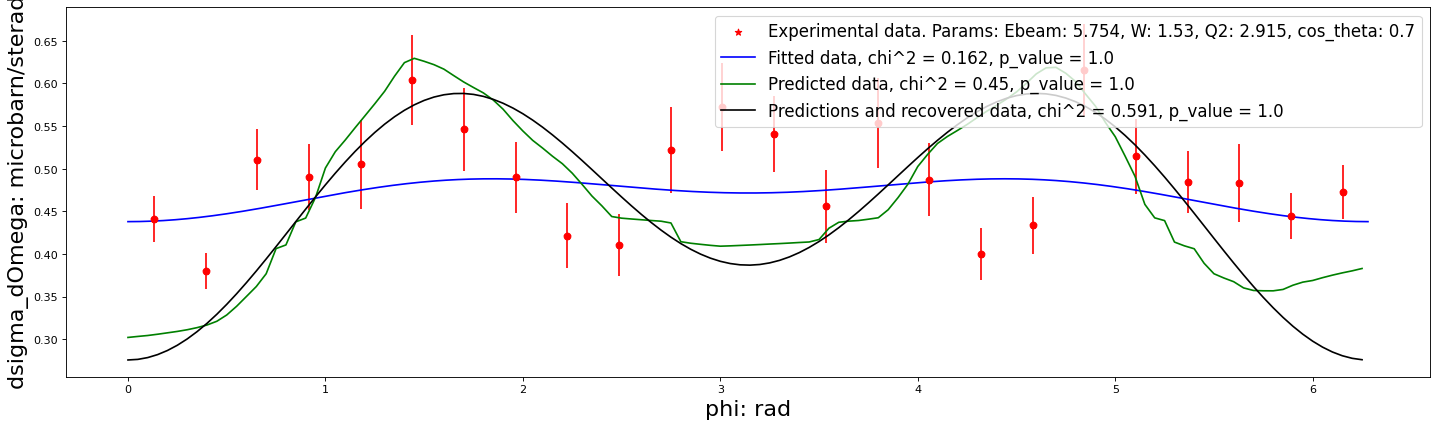

0 5.754 1.53 2.915 0.8
5.754 1.53 2.915 0.8


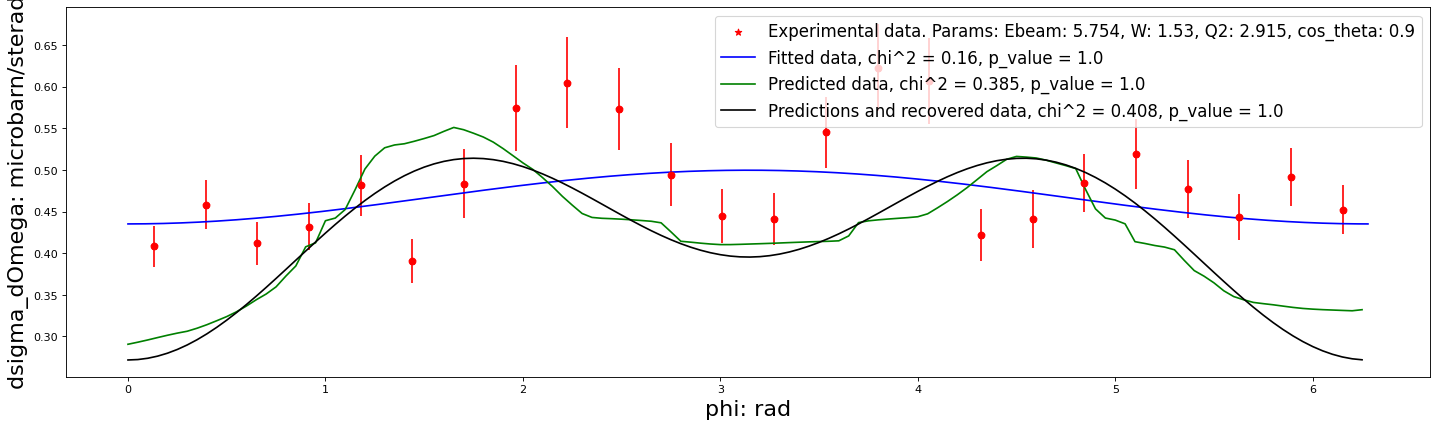


 50%|█████     | 2/4 [00:04<00:04,  2.23s/it]

0 5.754 1.715 2.915 -0.9
5.754 1.715 2.915 -0.9
0 5.754 1.715 2.915 -0.8
5.754 1.715 2.915 -0.8
0 5.754 1.715 2.915 -0.7
5.754 1.715 2.915 -0.7
0 5.754 1.715 2.915 -0.6
5.754 1.715 2.915 -0.6
0 5.754 1.715 2.915 -0.5
5.754 1.715 2.915 -0.5
0 5.754 1.715 2.915 -0.4
5.754 1.715 2.915 -0.4
0 5.754 1.715 2.915 -0.3
5.754 1.715 2.915 -0.3
0 5.754 1.715 2.915 -0.2
5.754 1.715 2.915 -0.2
0 5.754 1.715 2.915 -0.1
5.754 1.715 2.915 -0.1
0 5.754 1.715 2.915 0.1
5.754 1.715 2.915 0.1



 75%|███████▌  | 3/4 [00:04<00:01,  1.39s/it]

0 5.754 1.715 2.915 0.2
5.754 1.715 2.915 0.2
0 5.754 1.715 2.915 0.3
5.754 1.715 2.915 0.3
0 5.754 1.715 2.915 0.4
5.754 1.715 2.915 0.4
0 5.754 1.715 2.915 0.5
5.754 1.715 2.915 0.5
0 5.754 1.715 2.915 0.6
5.754 1.715 2.915 0.6
0 5.754 1.715 2.915 0.7
5.754 1.715 2.915 0.7
0 5.754 1.715 2.915 0.8
5.754 1.715 2.915 0.8
0 5.754 1.715 2.915 0.9
5.754 1.715 2.915 0.9
0 5.754 1.95 2.915 -0.9
5.754 1.95 2.915 -0.9
0 5.754 1.95 2.915 -0.8
5.754 1.95 2.915 -0.8
0 5.754 1.95 2.915 -0.7
5.754 1.95 2.915 -0.7
0 5.754 1.95 2.915 -0.6
5.754 1.95 2.915 -0.6
0 5.754 1.95 2.915 -0.5
5.754 1.95 2.915 -0.5
0 5.754 1.95 2.915 -0.4
5.754 1.95 2.915 -0.4
0 5.754 1.95 2.915 -0.3
5.754 1.95 2.915 -0.3
0 5.754 1.95 2.915 -0.2
5.754 1.95 2.915 -0.2
0 5.754 1.95 2.915 -0.1
5.754 1.95 2.915 -0.1
0 5.754 1.95 2.915 0.1
5.754 1.95 2.915 0.1
0 5.754 1.95 2.915 0.2
5.754 1.95 2.915 0.2
0 5.754 1.95 2.915 0.3
5.754 1.95 2.915 0.3



 67%|██████▋   | 4/6 [00:13<00:06,  3.50s/it]

0 5.754 1.95 2.915 0.4
5.754 1.95 2.915 0.4
0 5.754 1.95 2.915 0.5
5.754 1.95 2.915 0.5
0 5.754 1.95 2.915 0.6
5.754 1.95 2.915 0.6
0 5.754 1.95 2.915 0.7
5.754 1.95 2.915 0.7
0 5.754 1.95 2.915 0.8
5.754 1.95 2.915 0.8
0 5.754 1.95 2.915 0.9
5.754 1.95 2.915 0.9



  0%|          | 0/4 [00:00<?, ?it/s]

0 5.754 1.23 3.48 -0.9
5.754 1.23 3.48 -0.9
0 5.754 1.23 3.48 -0.8
5.754 1.23 3.48 -0.8
0 5.754 1.23 3.48 -0.7
5.754 1.23 3.48 -0.7
0 5.754 1.23 3.48 -0.6
5.754 1.23 3.48 -0.6
0 5.754 1.23 3.48 -0.5
5.754 1.23 3.48 -0.5
0 5.754 1.23 3.48 -0.4
5.754 1.23 3.48 -0.4
0 5.754 1.23 3.48 -0.3
5.754 1.23 3.48 -0.3
0 5.754 1.23 3.48 -0.2
5.754 1.23 3.48 -0.2
0 5.754 1.23 3.48 -0.1
5.754 1.23 3.48 -0.1
0 5.754 1.23 3.48 0.1
5.754 1.23 3.48 0.1
0 5.754 1.23 3.48 0.2
5.754 1.23 3.48 0.2
0 5.754 1.23 3.48 0.3
5.754 1.23 3.48 0.3
0 5.754 1.23 3.48 0.4
5.754 1.23 3.48 0.4
0 5.754 1.23 3.48 0.5
5.754 1.23 3.48 0.5



 25%|██▌       | 1/4 [00:00<00:01,  2.55it/s]

0 5.754 1.23 3.48 0.6
5.754 1.23 3.48 0.6
0 5.754 1.23 3.48 0.7
5.754 1.23 3.48 0.7
0 5.754 1.23 3.48 0.8
5.754 1.23 3.48 0.8
0 5.754 1.23 3.48 0.9
5.754 1.23 3.48 0.9
0 5.754 1.53 3.48 -0.9
5.754 1.53 3.48 -0.9
0 5.754 1.53 3.48 -0.8
5.754 1.53 3.48 -0.8
0 5.754 1.53 3.48 -0.7
5.754 1.53 3.48 -0.7
0 5.754 1.53 3.48 -0.6
5.754 1.53 3.48 -0.6
0 5.754 1.53 3.48 -0.5
5.754 1.53 3.48 -0.5
0 5.754 1.53 3.48 -0.4
5.754 1.53 3.48 -0.4
0 5.754 1.53 3.48 -0.3
5.754 1.53 3.48 -0.3
0 5.754 1.53 3.48 -0.2
5.754 1.53 3.48 -0.2
0 5.754 1.53 3.48 -0.1
5.754 1.53 3.48 -0.1
0 5.754 1.53 3.48 0.1
5.754 1.53 3.48 0.1
0 5.754 1.53 3.48 0.2
5.754 1.53 3.48 0.2
0 5.754 1.53 3.48 0.3
5.754 1.53 3.48 0.3
0 5.754 1.53 3.48 0.4
5.754 1.53 3.48 0.4
0 5.754 1.53 3.48 0.5
5.754 1.53 3.48 0.5
0 5.754 1.53 3.48 0.6
5.754 1.53 3.48 0.6
0 5.754 1.53 3.48 0.7
5.754 1.53 3.48 0.7



 50%|█████     | 2/4 [00:00<00:00,  2.53it/s]

0 5.754 1.53 3.48 0.8
5.754 1.53 3.48 0.8
0 5.754 1.53 3.48 0.9
5.754 1.53 3.48 0.9
0 5.754 1.715 3.48 -0.9
5.754 1.715 3.48 -0.9
0 5.754 1.715 3.48 -0.8
5.754 1.715 3.48 -0.8
0 5.754 1.715 3.48 -0.7
5.754 1.715 3.48 -0.7
0 5.754 1.715 3.48 -0.6
5.754 1.715 3.48 -0.6
0 5.754 1.715 3.48 -0.5
5.754 1.715 3.48 -0.5
0 5.754 1.715 3.48 -0.4
5.754 1.715 3.48 -0.4
0 5.754 1.715 3.48 -0.3
5.754 1.715 3.48 -0.3
0 5.754 1.715 3.48 -0.2
5.754 1.715 3.48 -0.2
0 5.754 1.715 3.48 -0.1
5.754 1.715 3.48 -0.1
0 5.754 1.715 3.48 0.1
5.754 1.715 3.48 0.1
0 5.754 1.715 3.48 0.2
5.754 1.715 3.48 0.2
0 5.754 1.715 3.48 0.3
5.754 1.715 3.48 0.3
0 5.754 1.715 3.48 0.4
5.754 1.715 3.48 0.4
0 5.754 1.715 3.48 0.5
5.754 1.715 3.48 0.5
0 5.754 1.715 3.48 0.6
5.754 1.715 3.48 0.6
0 5.754 1.715 3.48 0.7
5.754 1.715 3.48 0.7
0 5.754 1.715 3.48 0.8
5.754 1.715 3.48 0.8



 75%|███████▌  | 3/4 [00:01<00:00,  2.51it/s]

0 5.754 1.715 3.48 0.9
5.754 1.715 3.48 0.9
0 5.754 1.95 3.48 -0.9
5.754 1.95 3.48 -0.9
0 5.754 1.95 3.48 -0.8
5.754 1.95 3.48 -0.8
0 5.754 1.95 3.48 -0.7
5.754 1.95 3.48 -0.7
0 5.754 1.95 3.48 -0.6
5.754 1.95 3.48 -0.6
0 5.754 1.95 3.48 -0.5
5.754 1.95 3.48 -0.5
0 5.754 1.95 3.48 -0.4
5.754 1.95 3.48 -0.4
0 5.754 1.95 3.48 -0.3
5.754 1.95 3.48 -0.3
0 5.754 1.95 3.48 -0.2
5.754 1.95 3.48 -0.2
0 5.754 1.95 3.48 -0.1
5.754 1.95 3.48 -0.1
0 5.754 1.95 3.48 0.1
5.754 1.95 3.48 0.1
0 5.754 1.95 3.48 0.2
5.754 1.95 3.48 0.2
0 5.754 1.95 3.48 0.3
5.754 1.95 3.48 0.3
0 5.754 1.95 3.48 0.4
5.754 1.95 3.48 0.4



 83%|████████▎ | 5/6 [00:15<00:02,  2.81s/it]

0 5.754 1.95 3.48 0.5
5.754 1.95 3.48 0.5
0 5.754 1.95 3.48 0.6
5.754 1.95 3.48 0.6
0 5.754 1.95 3.48 0.7
5.754 1.95 3.48 0.7
0 5.754 1.95 3.48 0.8
5.754 1.95 3.48 0.8
0 5.754 1.95 3.48 0.9
5.754 1.95 3.48 0.9



  0%|          | 0/4 [00:00<?, ?it/s]

0 5.754 1.23 4.155 -0.9
5.754 1.23 4.155 -0.9
0 5.754 1.23 4.155 -0.8
5.754 1.23 4.155 -0.8
0 5.754 1.23 4.155 -0.7
5.754 1.23 4.155 -0.7
0 5.754 1.23 4.155 -0.6
5.754 1.23 4.155 -0.6
0 5.754 1.23 4.155 -0.5
5.754 1.23 4.155 -0.5
0 5.754 1.23 4.155 -0.4
5.754 1.23 4.155 -0.4
0 5.754 1.23 4.155 -0.3
5.754 1.23 4.155 -0.3
0 5.754 1.23 4.155 -0.2
5.754 1.23 4.155 -0.2
0 5.754 1.23 4.155 -0.1
5.754 1.23 4.155 -0.1
0 5.754 1.23 4.155 0.1
5.754 1.23 4.155 0.1
0 5.754 1.23 4.155 0.2
5.754 1.23 4.155 0.2
0 5.754 1.23 4.155 0.3
5.754 1.23 4.155 0.3
0 5.754 1.23 4.155 0.4
5.754 1.23 4.155 0.4
0 5.754 1.23 4.155 0.5
5.754 1.23 4.155 0.5



 25%|██▌       | 1/4 [00:00<00:01,  2.53it/s]

0 5.754 1.23 4.155 0.6
5.754 1.23 4.155 0.6
0 5.754 1.23 4.155 0.7
5.754 1.23 4.155 0.7
0 5.754 1.23 4.155 0.8
5.754 1.23 4.155 0.8
0 5.754 1.23 4.155 0.9
5.754 1.23 4.155 0.9
0 5.754 1.53 4.155 -0.9
5.754 1.53 4.155 -0.9
0 5.754 1.53 4.155 -0.8
5.754 1.53 4.155 -0.8
0 5.754 1.53 4.155 -0.7
5.754 1.53 4.155 -0.7
0 5.754 1.53 4.155 -0.6
5.754 1.53 4.155 -0.6
0 5.754 1.53 4.155 -0.5
5.754 1.53 4.155 -0.5
0 5.754 1.53 4.155 -0.4
5.754 1.53 4.155 -0.4
0 5.754 1.53 4.155 -0.3
5.754 1.53 4.155 -0.3
0 5.754 1.53 4.155 -0.2
5.754 1.53 4.155 -0.2
0 5.754 1.53 4.155 -0.1
5.754 1.53 4.155 -0.1
0 5.754 1.53 4.155 0.1
5.754 1.53 4.155 0.1
0 5.754 1.53 4.155 0.2
5.754 1.53 4.155 0.2
0 5.754 1.53 4.155 0.3
5.754 1.53 4.155 0.3
0 5.754 1.53 4.155 0.4
5.754 1.53 4.155 0.4
0 5.754 1.53 4.155 0.5
5.754 1.53 4.155 0.5
0 5.754 1.53 4.155 0.6
5.754 1.53 4.155 0.6



 50%|█████     | 2/4 [00:00<00:00,  2.51it/s]

0 5.754 1.53 4.155 0.7
5.754 1.53 4.155 0.7
0 5.754 1.53 4.155 0.8
5.754 1.53 4.155 0.8
0 5.754 1.53 4.155 0.9
5.754 1.53 4.155 0.9
0 5.754 1.715 4.155 -0.9
5.754 1.715 4.155 -0.9
0 5.754 1.715 4.155 -0.8
5.754 1.715 4.155 -0.8
0 5.754 1.715 4.155 -0.7
5.754 1.715 4.155 -0.7
0 5.754 1.715 4.155 -0.6
5.754 1.715 4.155 -0.6
0 5.754 1.715 4.155 -0.5
5.754 1.715 4.155 -0.5
0 5.754 1.715 4.155 -0.4
5.754 1.715 4.155 -0.4
0 5.754 1.715 4.155 -0.3
5.754 1.715 4.155 -0.3
0 5.754 1.715 4.155 -0.2
5.754 1.715 4.155 -0.2
0 5.754 1.715 4.155 -0.1
5.754 1.715 4.155 -0.1
0 5.754 1.715 4.155 0.1
5.754 1.715 4.155 0.1
0 5.754 1.715 4.155 0.2
5.754 1.715 4.155 0.2
0 5.754 1.715 4.155 0.3
5.754 1.715 4.155 0.3
0 5.754 1.715 4.155 0.4
5.754 1.715 4.155 0.4
0 5.754 1.715 4.155 0.5
5.754 1.715 4.155 0.5
0 5.754 1.715 4.155 0.6
5.754 1.715 4.155 0.6
0 5.754 1.715 4.155 0.7
5.754 1.715 4.155 0.7



 75%|███████▌  | 3/4 [00:01<00:00,  2.51it/s]

0 5.754 1.715 4.155 0.8
5.754 1.715 4.155 0.8
0 5.754 1.715 4.155 0.9
5.754 1.715 4.155 0.9
0 5.754 1.95 4.155 -0.9
5.754 1.95 4.155 -0.9
0 5.754 1.95 4.155 -0.8
5.754 1.95 4.155 -0.8
0 5.754 1.95 4.155 -0.7
5.754 1.95 4.155 -0.7
0 5.754 1.95 4.155 -0.6
5.754 1.95 4.155 -0.6
0 5.754 1.95 4.155 -0.5
5.754 1.95 4.155 -0.5
0 5.754 1.95 4.155 -0.4
5.754 1.95 4.155 -0.4
0 5.754 1.95 4.155 -0.3
5.754 1.95 4.155 -0.3
0 5.754 1.95 4.155 -0.2
5.754 1.95 4.155 -0.2
0 5.754 1.95 4.155 -0.1
5.754 1.95 4.155 -0.1
0 5.754 1.95 4.155 0.1
5.754 1.95 4.155 0.1
0 5.754 1.95 4.155 0.2
5.754 1.95 4.155 0.2
0 5.754 1.95 4.155 0.3
5.754 1.95 4.155 0.3
0 5.754 1.95 4.155 0.4
5.754 1.95 4.155 0.4
0 5.754 1.95 4.155 0.5
5.754 1.95 4.155 0.5
0 5.754 1.95 4.155 0.6
5.754 1.95 4.155 0.6
0 5.754 1.95 4.155 0.7
5.754 1.95 4.155 0.7
0 5.754 1.95 4.155 0.8
5.754 1.95 4.155 0.8



100%|██████████| 6/6 [00:16<00:00,  2.78s/it]

0 5.754 1.95 4.155 0.9
5.754 1.95 4.155 0.9


In [39]:
for Q2 in tqdm.tqdm([1.715, 2.050, 2.445, 2.915, 3.480, 4.155]):
    os.makedirs(f"./final_checks/3_models/cross_sections/E_beam={Ebeam}/Q2={Q2}")
    for W in tqdm.tqdm([1.23, 1.53, 1.715, 1.95]):
        os.makedirs(f"./final_checks/3_models/cross_sections/E_beam={Ebeam}/Q2={Q2}/W={W}")
        for cos_theta in [-0.9,-0.8,-0.7,-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
            try:
                plot_joint_cross_sections(df, Ebeam, W, Q2, cos_theta, df_grid)
            except:
                print(Ebeam, W, Q2, cos_theta)